# **Forecasting Realized Volatility**

In contrast to *implied volatility* (IV), which reflects the market’s expectation of future uncertainty, *realized volatility* (RV) corresponds to the volatility that actually materializes over a given horizon. From a modeling perspective, RV exhibits strong persistence and clustering, making it more forecastable than IV or returns themselves.

## Why Forecast Realized Volatility?

Forecasting RV is valuable for several reasons in both trading and risk management:

- **Volatility Trading & IV–RV Strategies**  
  Accurate RV forecasts allow us to identify mispricings between implied and realized volatility.  
  For example, if IV is significantly higher than the forecasted RV, it may indicate an opportunity to short volatility and harvest the volatility risk premium (VRP).

- **Position Sizing**  
  Forecasted volatility can be used to dynamically scale positions: larger sizes in calm regimes, smaller sizes in volatile markets.  
  This volatility targeting improves risk-adjusted returns.

- **Risk Management (Stop Loss / Take Profit)**  
  RV forecasts help set realistic expectations for daily or monthly moves, which can inform stop-loss and take-profit levels in directional strategies.

---

By systematically modeling and forecasting RV — using approaches such as HAR models, GARCH-type processes, or machine learning — we can generate signals that are not only academically robust but also directly actionable in trading strategies.


The notebook is structured as follows:

1. [Read & Prepare Data](#read_data)
2. [Volatility Estimators](#real-vol)
   - [2.1. Historical (close-to-close): 10D, 21D, 100D](#trade-execution-setup)
   - [2.2. Range-based (OHLC): Parkinson, GK, Rogers-Satchel, Yang Zhang](#trade-execution-setup)
   - [2.3. High-Frequency Estimators: Realized Variance](#e)
3. [Stylized facts of realized volatility](#real-vol)
4. [Predictors of realized volatility](#real-vol)
5. [Forecasting Models](#real-vol)
6. [Evaluation: Walk forward with cross val, RMSE vs QLIKE, plotting residuals, refitting models every months](#real-vol)

In [1]:
%load_ext autoreload
%autoreload 2

import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

from dotenv import load_dotenv
from matplotlib import gridspec
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

np.random.seed(42)

%matplotlib inline
plt.style.use('seaborn-v0_8-darkgrid')

pd.options.mode.chained_assignment = None 

# **1. Read & Prepare Data**

For this analysis we are going to consider daily S&P500 OHLC data from Yahoo finance from `2018` to `2025` and prepare it for analysis.

In [2]:
start = "2015-01-01"
end = "2020-12-31"

spx = yf.download("^GSPC", start=start, end=end, auto_adjust=True)
spx.columns = spx.columns.droplevel("Ticker")
spx.columns.name = None
spx

[*********************100%***********************]  1 of 1 completed


,Close,High,Low,Open,Volume
Date,,,,,
2015-01-02,2058.199951,2072.360107,2046.040039,2058.899902,2708700000
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000
...,...,...,...,...,...
2020-12-23,3690.010010,3711.239990,3689.280029,3693.419922,3779160000
2020-12-24,3703.060059,3703.820068,3689.320068,3694.030029,1883780000
2020-12-28,3735.360107,3740.510010,3723.030029,3723.030029,3535460000


In [3]:
spx.isna().sum()

Close     0
High      0
Low       0
Open      0
Volume    0
dtype: int64

In [4]:
spx["returns"] = np.log(spx["Close"] / spx["Close"].shift(1))
spx = spx.dropna()
spx

,Close,High,Low,Open,Volume,returns
Date,,,,,,
2015-01-05,2020.579956,2054.439941,2017.339966,2054.439941,3799120000,-0.018447
2015-01-06,2002.609985,2030.250000,1992.439941,2022.150024,4460110000,-0.008933
2015-01-07,2025.900024,2029.609985,2005.550049,2005.550049,3805480000,0.011563
2015-01-08,2062.139893,2064.080078,2030.609985,2030.609985,3934010000,0.017730
2015-01-09,2044.810059,2064.429932,2038.329956,2063.449951,3364140000,-0.008439
...,...,...,...,...,...,...
2020-12-23,3690.010010,3711.239990,3689.280029,3693.419922,3779160000,0.000746
2020-12-24,3703.060059,3703.820068,3689.320068,3694.030029,1883780000,0.003530
2020-12-28,3735.360107,3740.510010,3723.030029,3723.030029,3535460000,0.008685


Text(0.5, 1.0, 'Log Returns')

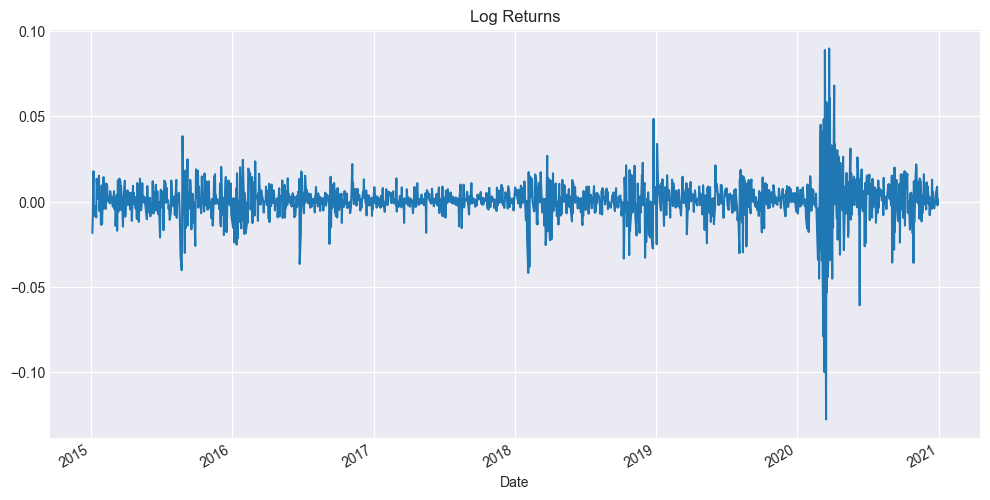

In [5]:
spx["returns"].plot(figsize=(12, 6))
plt.title("Log Returns")

# **2. Volatility Estimators**

Volatility is a *latent* quantity — it cannot be observed directly. To evaluate forecasts and build predictors, we need to construct **proxies** from price data. Different estimators trade off bias vs efficiency depending on the sampling frequency and data available.

## 2.1 Historical / Close-to-Close

The simplest approach uses only closing price data and is often called the **close-to-close estimator**.   It computes realized volatility from consecutive daily returns. This estimator serves as a useful **benchmark**, but it suffers from several drawbacks: it ignores intraday variation, overnight jumps, and the information contained in opening, high, and low prices, which often makes it downward biased.

Formally, over a horizon $H$:

$$
RV_{t,H} = \sqrt{\tfrac{252}{H} \sum_{j=1}^H r_{t+j}^2}, 
\quad r_t = \ln\left(\frac{P_t}{P_{t-1}}\right)
$$

In [6]:
def rv_close_to_close(returns, h=21, ann=252):
    var = returns.pow(2).rolling(h).sum() * (ann / h)
    return np.sqrt(var)

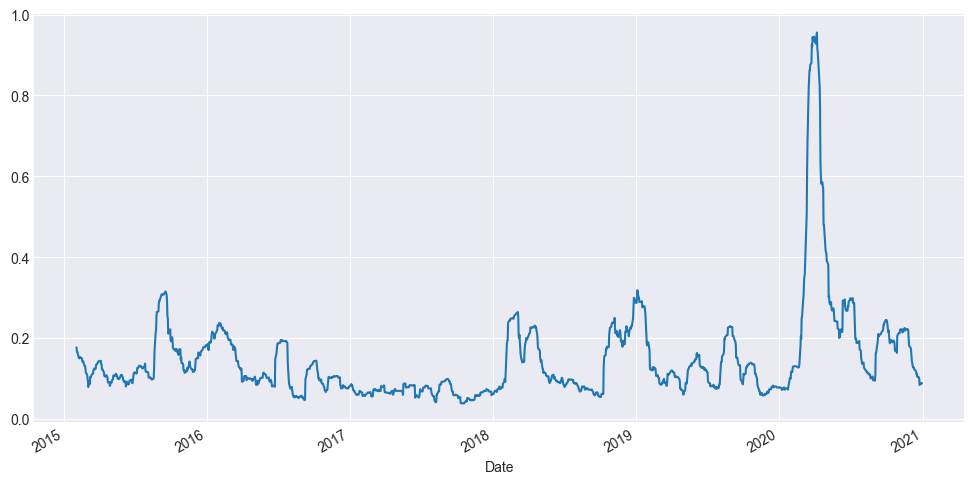

In [7]:
spx["rv_close"] = rv_close_to_close(spx["returns"], h=21)
spx["rv_close"].plot(figsize=(12, 6))
plt.show()

## 2.2 Range-Based Proxies (OHLC)

Instead of relying only on closing prices, we can extract more information from each trading day by incorporating the **Open, High, Low, and Close (OHLC)** prices.  
Over the years, several range-based estimators have been proposed, each addressing specific shortcomings of the close-to-close method and earlier estimators.  
These approaches typically reduce variance in the volatility estimate and account for intraday dynamics, but each comes with its own assumptions and limitations.

### 2.2.1 Parkinson Estimator

The **Parkinson (1980) estimator** uses the daily high–low range to capture intraday price variability.  
By relying on the full range rather than just closing prices, it provides a more efficient estimate of volatility under the assumption of a **driftless geometric Brownian motion**.  

However, it ignores opening and closing prices and is highly sensitive to jumps or bid–ask bounce at the extremes of the trading day.

Formally, over a horizon $H$:

$$
RV^{\text{Parkinson}}_{t,H} 
= \sqrt{ \frac{252}{4H \ln(2)} \sum_{j=1}^H \left[ \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right]^2 }
$$

In [8]:
def rv_parkinson(high, low, h=21, ann=252):
    rp = np.log(high / low).pow(2)  # per-day range variance proxy
    var = rp.rolling(h, min_periods=h).sum() * (ann / (4 * np.log(2) * h))
    return np.sqrt(var)

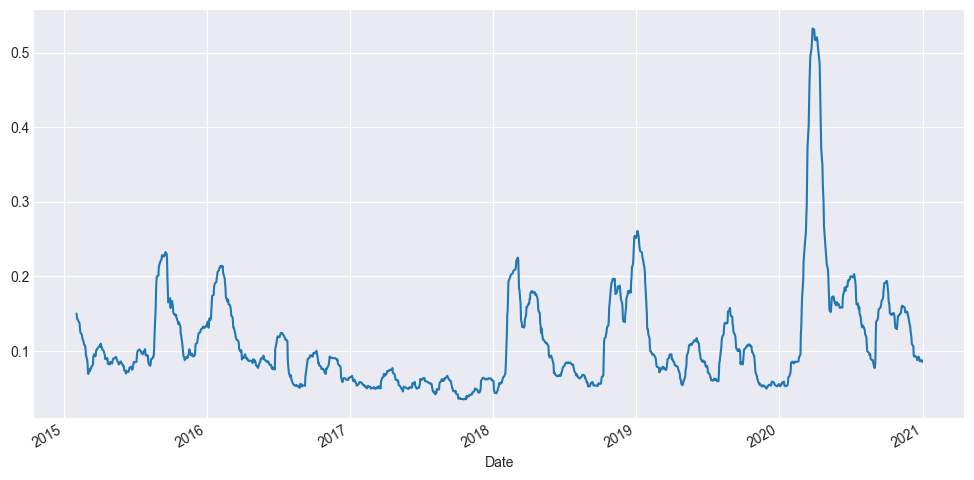

In [9]:
spx["rv_parkinson"] = rv_parkinson(spx["High"], spx["Low"], h=21)
spx["rv_parkinson"].plot(figsize=(12, 6))
plt.show()

### 2.2.2 Garman–Klass Estimator

The **Garman–Klass (1980) estimator** improves upon the Parkinson measure by incorporating not only the daily high and low, but also the open and close prices.  
This allows it to capture more information about intraday price variation and reduce estimation variance under the assumption of a driftless geometric Brownian motion.  

However, like the Parkinson estimator, it can be biased in the presence of significant drift or opening jumps, since it assumes zero drift and continuous trading.

Formally, over a horizon $H$:

$$
RV^{\text{GK}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ \tfrac{1}{2} \left( \ln\!\left(\tfrac{H_{t+j}}{L_{t+j}}\right) \right)^2 
- (2\ln(2) - 1) \left( \ln\!\left(\tfrac{C_{t+j}}{O_{t+j}}\right) \right)^2 
\right] }
$$

In [10]:
def rv_garman_klass(open_, high, low, close, h=21, ann=252):
    # Daily GK variance (no drift)
    rs = 0.5 * (np.log(high/low).pow(2)) - (2*np.log(2) - 1) * (np.log(close/open_).pow(2))
    var = rs.rolling(h).sum() * (ann / h)
    return np.sqrt(var)

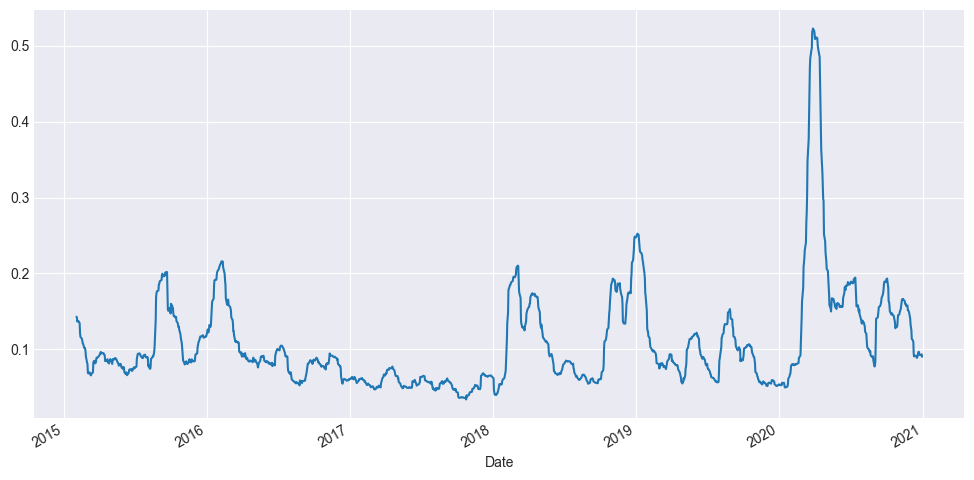

In [11]:
spx["rv_gk"] = rv_garman_klass(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_gk"].plot(figsize=(12, 6))
plt.show()

### 2.2.3 Rogers–Satchell Estimator

The **Rogers–Satchell (1991) estimator** was introduced to overcome one of the limitations of the Parkinson and Garman–Klass estimators: their assumption of zero drift.  
The Rogers–Satchell measure is **drift-robust**, making it better suited for assets that experience trending behavior.  
It uses all four OHLC prices, but in a different functional form that explicitly accommodates nonzero expected returns.  

While it handles drift effectively, it remains sensitive to microstructure noise and extreme jumps at the open or close.

Formally, over a horizon $H$:

$$
RV^{\text{RS}}_{t,H} 
= \sqrt{ \frac{252}{H} \sum_{j=1}^H 
\left[ 
\ln\!\left(\tfrac{H_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{H_{t+j}}{O_{t+j}}\right) 
+ \ln\!\left(\tfrac{L_{t+j}}{C_{t+j}}\right) \cdot \ln\!\left(\tfrac{L_{t+j}}{O_{t+j}}\right) 
\right] }
$$

In [12]:
def rv_rogers_satchell(open_, high, low, close, h=21, ann=252):
    term1 = np.log(high/close) * np.log(high/open_)
    term2 = np.log(low/close) * np.log(low/open_)
    rs = (term1 + term2)
    var = rs.rolling(h).sum() * (ann/h)
    return np.sqrt(var)

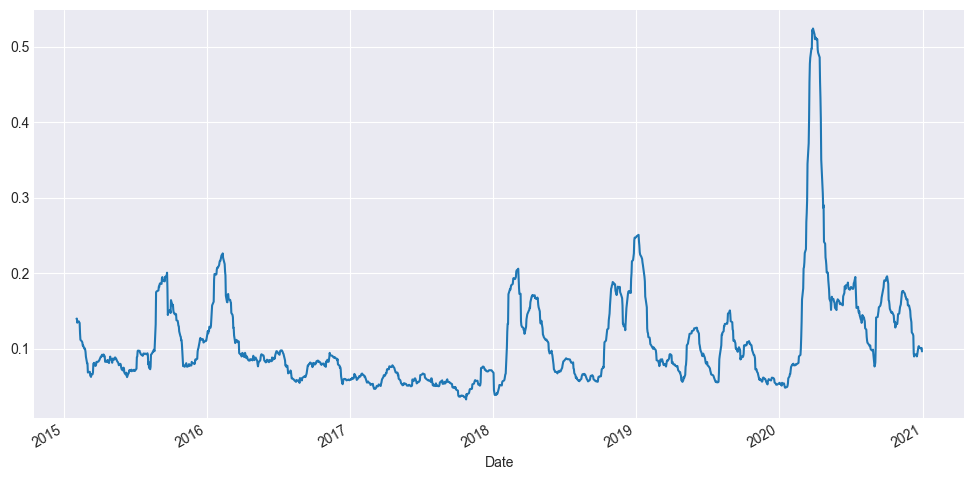

In [13]:
spx["rv_rs"] = rv_rogers_satchell(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_rs"].plot(figsize=(12, 6))
plt.show()

### 2.2.4 Yang–Zhang Estimator

The **Yang–Zhang (2000) estimator** combines the advantages of previous methods by incorporating overnight variance, open-to-close variance, and the Rogers–Satchell range-based component.  
It is **unbiased in the presence of drift**, less sensitive to opening jumps, and has significantly lower estimation variance compared to Parkinson, Garman–Klass, or Rogers–Satchell taken alone.  

This makes Yang–Zhang one of the most efficient daily volatility estimators available when OHLC data are present.

Formally, the daily Yang–Zhang variance can be expressed as:

$$
\sigma^2_{YZ} = \sigma^2_O + k \, \sigma^2_C + (1-k)\, \sigma^2_{RS}
$$

where  
- $\sigma^2_O = \big( \ln(O_t / C_{t-1}) \big)^2$ is the overnight variance,  
- $\sigma^2_C = \big( \ln(C_t / O_t) \big)^2$ is the open-to-close variance,  
- $\sigma^2_{RS}$ is the Rogers–Satchell variance component,  
- $k \approx 0.34$ is a weight chosen to minimize bias and variance.  

Aggregating over a horizon $H$:

$$
RV^{\text{YZ}}_{t,H} = \sqrt{ \frac{252}{H} \sum_{j=1}^H \sigma^2_{YZ,\,t+j} }
$$

In [14]:
def rv_yang_zhang(open_, high, low, close, h=21, ann=252, k=0.34):
    # Overnight return variance
    oc = np.log(open_/close.shift(1))
    sigma_o = oc.pow(2)

    # Open-to-close variance
    co = np.log(close/open_)
    sigma_c = co.pow(2)

    # Rogers–Satchell component
    rs = (
        np.log(high/close) * np.log(high/open_) +
        np.log(low/close) * np.log(low/open_)
    )

    # Daily YZ variance
    yz = sigma_o + k*sigma_c + (1-k)*rs

    var = yz.rolling(h, min_periods=h).sum() * (ann/h)
    return np.sqrt(var)

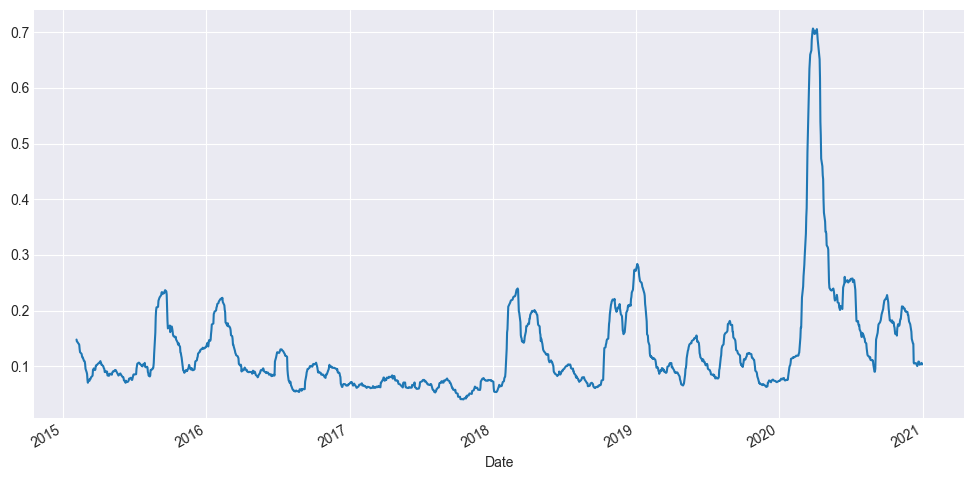

In [15]:
spx["rv_yz"] = rv_yang_zhang(spx["Open"], spx["High"], spx["Low"], spx["Close"], h=21)
spx["rv_yz"].plot(figsize=(12, 6))
plt.show()

## 2.3 Which Estimator to choose ?

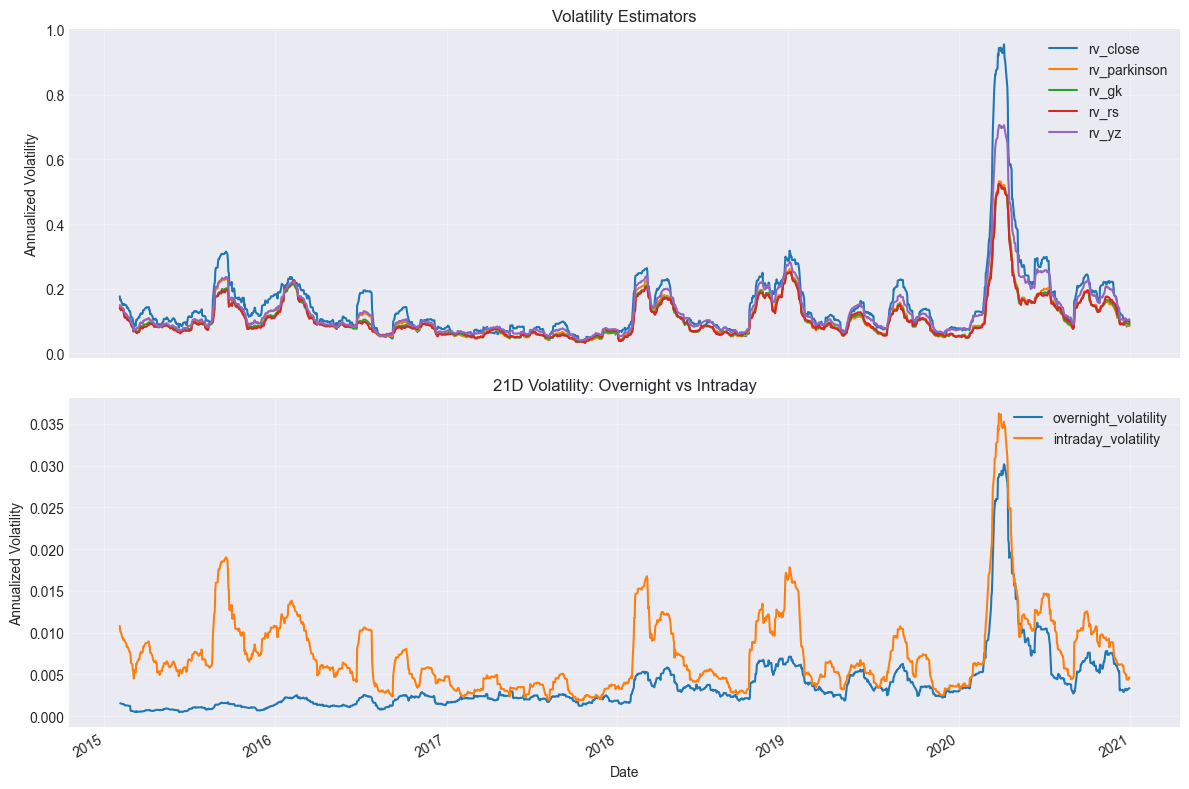

In [16]:
spx["overnight_volatility"] = np.log(spx["Open"] / spx["Close"].shift(1)).rolling(21).std()
spx["intraday_volatility"] = np.log(spx["Close"] / spx["Open"]).rolling(21).std()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# --- top panel: volatility estimators ---
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax1)
ax1.set_title("Volatility Estimators")
ax1.set_ylabel("Annualized Volatility")
ax1.grid(alpha=0.3)
ax1.legend()

# --- bottom panel: overnight vs intraday volatility ---
spx[["overnight_volatility", "intraday_volatility"]].plot(ax=ax2)
ax2.set_title("21D Volatility: Overnight vs Intraday")
ax2.set_ylabel("Annualized Volatility")
ax2.grid(alpha=0.3)
ax2.legend()

plt.tight_layout()
plt.show()

- **Insight:** You’ll see that in stress regimes (e.g., 2008, COVID-19 crash), *overnight moves dominate*. YZ explicitly accounts for this.

### 2.3 High-Frequency Estimators: Realized Variance

With **5-minute high-frequency data**, we can incorporate much more intraday information than when relying only on daily OHLC data.  
In this notebook, we use **E-mini S&P 500 futures (ES)**, which trade almost 24 hours a day, so the realized measure naturally includes overnight returns as well.  

The choice of a 5-minute sampling grid is widely recognized as the best trade-off between capturing information and avoiding microstructure distortions: it explains about **90–95% of daily integrated variance**. At higher frequencies (e.g., 1-min, tick), **microstructure noise**—such as bid–ask bounce and discrete price jumps—becomes more prominent, requiring more advanced techniques (e.g., **pre-averaged RV** or **realized kernels**).  

As a baseline, we consider the **realized variance (RV)** estimator, defined over a day $t$ with intraday returns $r_{t,i}$ as:

$$
RV_t = \sum_{i=1}^{N_t} r_{t,i}^2,
\quad 
r_{t,i} = \ln\!\left(\frac{P_{t,i}}{P_{t,i-1}}\right)
$$

where $N_t$ is the number of 5-minute intervals within day $t$, and $P_{t,i}$ denotes the price at interval $i$.

In [17]:
es_5min = pd.read_csv("data/intermediate/es-5m.csv", 
                 sep=";", 
                 header=None,
                 names=["date","time","open","high","low","close","volume"])

es_5min["datetime"] = pd.to_datetime(es_5min["date"] + " " + es_5min["time"], 
                                     format="%d/%m/%Y %H:%M:%S")

es_5min = es_5min.drop(columns=["date","time"]).set_index("datetime").sort_index()

es_5min = es_5min.loc[start:end]
es_5min

,open,high,low,close,volume
datetime,,,,,
2015-01-01 17:00:00,2055.00,2057.75,2055.00,2057.00,2626
2015-01-01 17:05:00,2056.75,2057.50,2056.75,2057.50,500
2015-01-01 17:10:00,2057.50,2058.00,2056.75,2058.00,930
2015-01-01 17:15:00,2058.00,2059.00,2057.75,2059.00,1121
2015-01-01 17:20:00,2058.75,2059.00,2058.75,2058.75,638
...,...,...,...,...,...
2020-12-31 15:35:00,3746.75,3747.25,3746.00,3746.75,902
2020-12-31 15:40:00,3746.75,3747.25,3746.50,3747.00,582
2020-12-31 15:45:00,3747.00,3747.50,3745.75,3746.75,879


In [18]:
es_5min.isna().sum()

open      0
high      0
low       0
close     0
volume    0
dtype: int64

In [19]:
es_5min[es_5min.index.duplicated(keep=False)]

,open,high,low,close,volume
datetime,,,,,


In [20]:
es_5min = es_5min[~es_5min.index.duplicated(keep="last")]

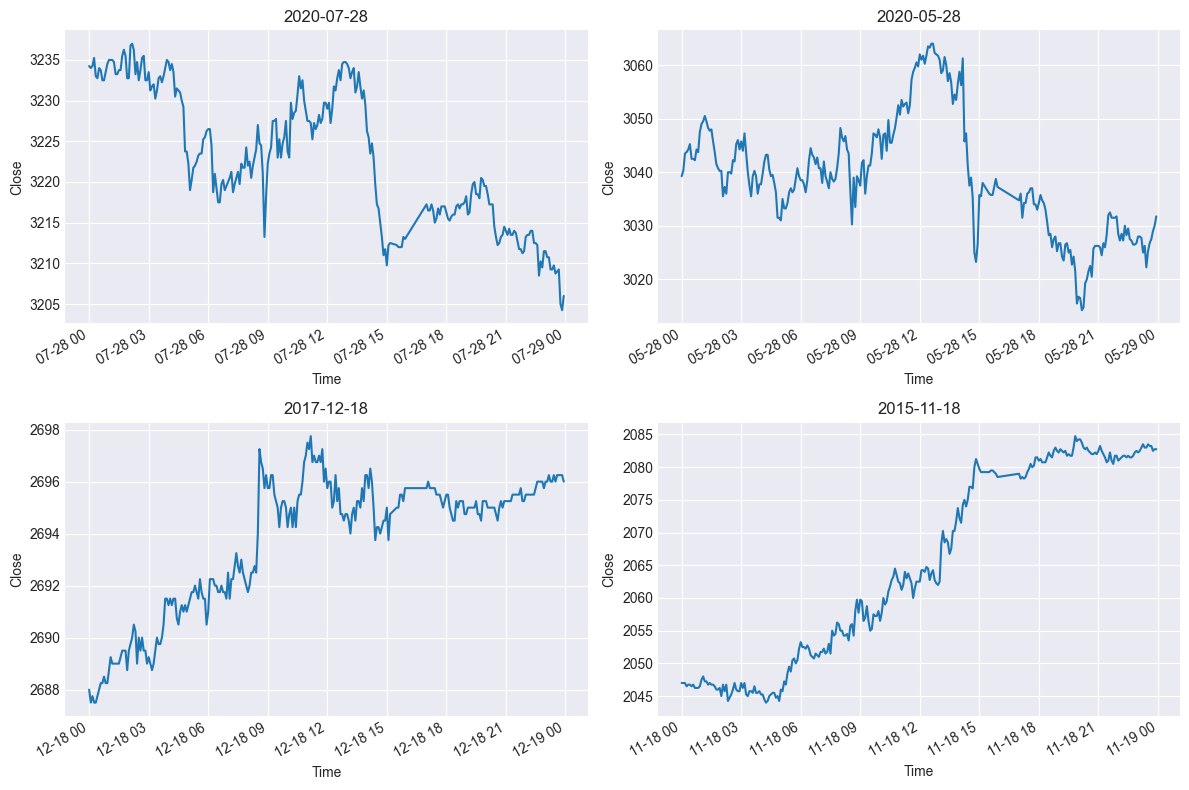

In [21]:
# pick 4 random days
all_days = es_5min.index.normalize().unique().date
days = np.random.choice(all_days, size=4, replace=False)

fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for ax, day in zip(axes.ravel(), days):
    es_5min.loc[str(day), "close"].plot(ax=ax)
    ax.set_title(day.strftime("%Y-%m-%d"))
    ax.set_xlabel("Time")
    ax.set_ylabel("Close")

plt.tight_layout()
plt.show()

There are some interpolated prices, but oeverall teh quality looks good comapred to yfinance for isnatcne where msot of the series would be interpolated.

In [22]:
def daily_realized_variance(close, rth_start: str = "09:30", rth_end: str = "16:00"):
    """
    Compute daily realized variance from intraday data:
        RV_t = sum_i r_{t,i}^2, where r_{t,i} = log(P_{t,i}/P_{t,i-1})
    """
    # intraday log returns
    tod = close.index.strftime("%H:%M")
    rth = close[(tod >= rth_start) & (tod <= rth_end)].copy()
    r = np.log(rth).diff()

    # sum of squared intraday returns by day
    rv_daily = r.pow(2).groupby(rth.index.date).sum()
    rv_daily.index = pd.to_datetime(rv_daily.index)
    rv_daily.name = "var_daily"

    return rv_daily

"""
def realized_volatility(
    close: pd.DataFrame,
    h: int = 21,
    ann: int = 252,
    rth_start: str = "09:30",
    rth_end: str = "16:00",
    method: str = "trailing",  # "trailing" or "forward"
    as_vol: bool = True       # return sqrt(var) if True
) -> pd.Series:

    Compute h-day realized variance/volatility from intraday prices.

    method:
        - "trailing": uses past h days up to t
        - "forward": uses next h days (t+1...t+h), aligned at t
    tod = close.index.strftime("%H:%M")
    rth = close[(tod >= rth_start) & (tod <= rth_end)].copy()

    # RTH intraday returns & variance
    r = np.log(rth).diff()
    var_rth = r.pow(2).groupby(rth.index.date).sum()
    var_rth.index = pd.to_datetime(var_rth.index)
    var_rth = var_rth.sort_index().rename("var_rth")

    if method == "trailing":
        var_h = var_rth.rolling(h, min_periods=h).sum()
    elif method == "forward":
        var_h = var_rth.rolling(h, min_periods=h).sum().shift(-h)
    else:
        raise ValueError("method must be 'trailing' or 'forward'")

    ann_var = var_h * (ann / h)
    if as_vol:
        return np.sqrt(ann_var).rename(f"rv{h}_ann_{method}")
    return ann_var.rename(f"var{h}_ann_{method}")

"""

'\ndef realized_volatility(\n    close: pd.DataFrame,\n    h: int = 21,\n    ann: int = 252,\n    rth_start: str = "09:30",\n    rth_end: str = "16:00",\n    method: str = "trailing",  # "trailing" or "forward"\n    as_vol: bool = True       # return sqrt(var) if True\n) -> pd.Series:\n\n    Compute h-day realized variance/volatility from intraday prices.\n\n    method:\n        - "trailing": uses past h days up to t\n        - "forward": uses next h days (t+1...t+h), aligned at t\n    tod = close.index.strftime("%H:%M")\n    rth = close[(tod >= rth_start) & (tod <= rth_end)].copy()\n\n    # RTH intraday returns & variance\n    r = np.log(rth).diff()\n    var_rth = r.pow(2).groupby(rth.index.date).sum()\n    var_rth.index = pd.to_datetime(var_rth.index)\n    var_rth = var_rth.sort_index().rename("var_rth")\n\n    if method == "trailing":\n        var_h = var_rth.rolling(h, min_periods=h).sum()\n    elif method == "forward":\n        var_h = var_rth.rolling(h, min_periods=h).sum().shift

In [23]:
daily_rv = daily_realized_variance(es_5min["close"])
es_rv_21 = np.sqrt(daily_rv.rolling(21).mean() * 252)

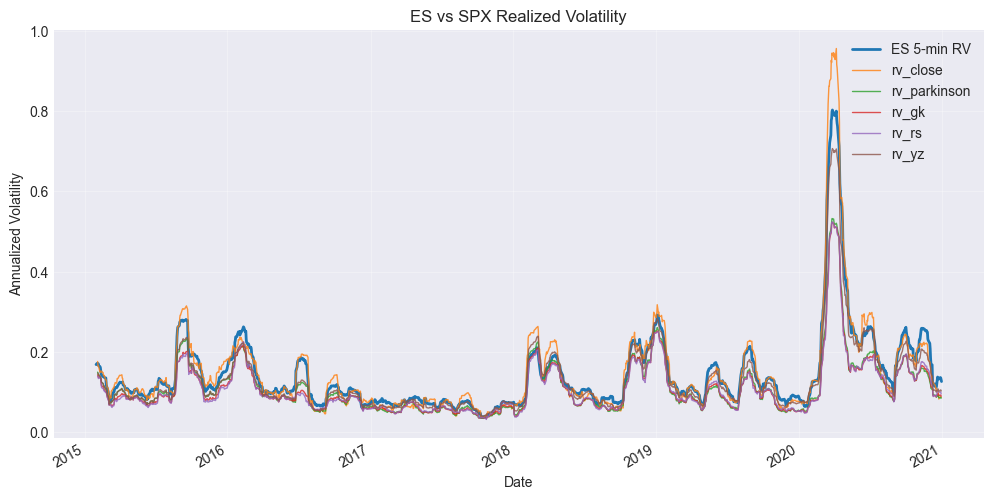

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

es_rv_21.plot(ax=ax, label="ES 5-min RV", lw=2)
spx.loc[:, spx.columns.str.startswith("rv")].plot(ax=ax, lw=1, alpha=0.8)

ax.set_title("ES vs SPX Realized Volatility")
ax.set_ylabel("Annualized Volatility")
ax.grid(alpha=0.3)
ax.legend()

plt.show()

The difference between close-to-close and realized variance is evne more pormiennt at daily frequency.

# **3. Stylized facts of daily volatility**

Here we will be investgating stylized facts of daily volatility that can be used for modelling perspective. The idea is to highlight the key charcetristics of daily varaicne that can be leveraged to forecast the future volaitltiy. From a modellign perspective it is betetr to work diertcly with varaicne instea dof std (isnce variance is additive) as well as dealing with the daily one isnetad of teh monthyl rollign one (which does not align with the stylized fatcs which come from daily frequency).

Volatility us 

- ACF-PACF of saurred returns (persistence)
- Volatiltiy clusterign & Mean reversion
- Leverage effect

## 3.1 Volatility clustering

It is the msot important phenomena as volatility is not constant, it evolves in low and high volatility regimes respecitvely. The idea is that high (resp. low) level of voalitlities tend to be follwoed by high (resp. low) level of volaitlity respectievly.

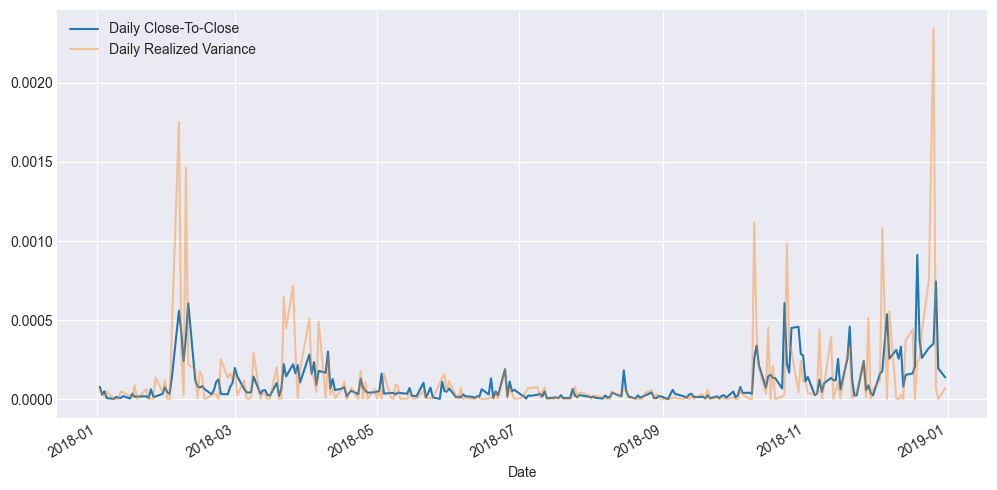

In [25]:
daily_c2c = spx["returns"].pow(2)

plt.figure(figsize=(12, 6))
daily_rv.loc["2018"].plot(alpha=1, label="Daily Close-To-Close")
daily_c2c.loc["2018"].plot(alpha=0.4, label="Daily Realized Variance")
plt.legend()
plt.show()

## 3.2 Long Memory / Slow Decay

Squarred retursn and realized varaicne show strong persiteenc eover many lags. Means today’s volatility has predictive power even months ahead. Thi smotivates the use of HAR-RV models that parsimuniusly include many lags until monthyl lags.

In [26]:
def plot_acf_pacf(series, lags=40, title=""):
    fig, axes = plt.subplots(1, 2, figsize=(14,4))

    plot_acf(series.dropna(), lags=lags, ax=axes[0])
    axes[0].set_title(f"ACF {title}")

    plot_pacf(series.dropna(), lags=lags, ax=axes[1], method="ywm")  # Yule-Walker-M estimator
    axes[1].set_title(f"PACF {title}")

    plt.tight_layout()
    plt.show()

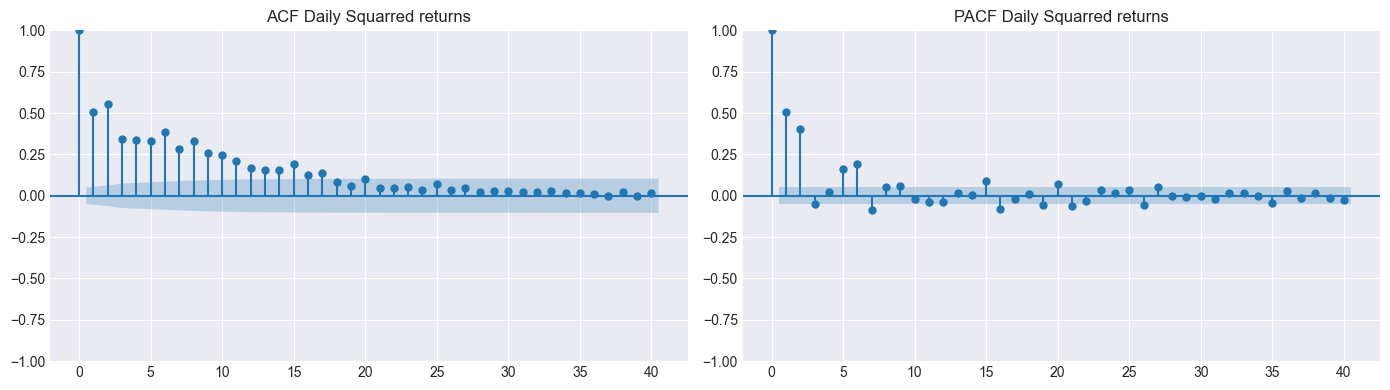

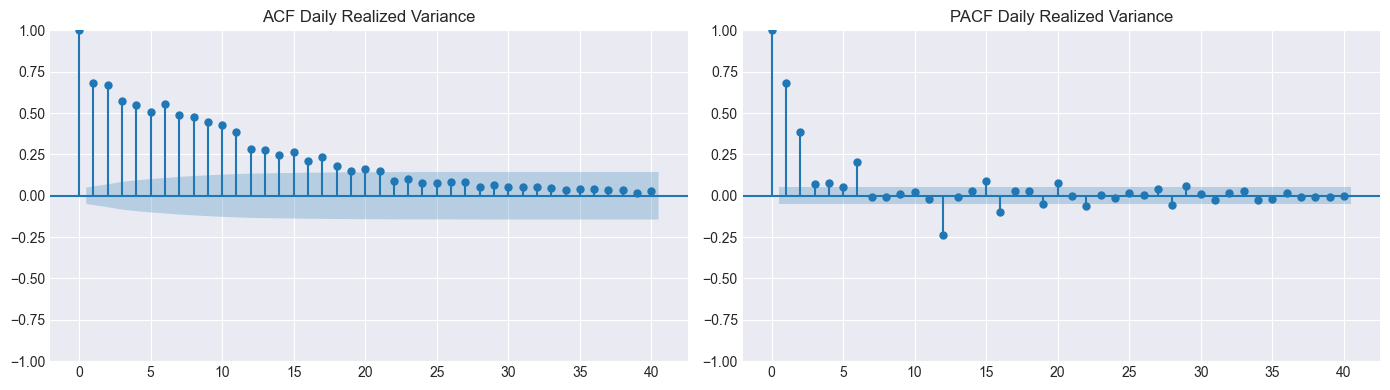

In [27]:
plot_acf_pacf(daily_c2c, lags=40, title="Daily Squarred returns")
plot_acf_pacf(daily_rv, lags=40, title="Daily Realized Variance")

For short horizons, the realized varaicne is more persitent than the close-to-close appromxiated by squarred returns with lags which ate meaningful until 1 months thus we could use autoregressive terms until the 21th to forecast teh next day volatility.

## 3.3 Mean-reverting behaviour

In [28]:
from statsmodels.tsa.ar_model import AutoReg

# Fit AR(1) model
model = AutoReg(daily_rv.to_numpy(), lags=1, old_names=False)
res = model.fit()
print(res.summary())

                            AutoReg Model Results                             
Dep. Variable:                      y   No. Observations:                 1547
Model:                     AutoReg(1)   Log Likelihood               10395.724
Method:               Conditional MLE   S.D. of innovations              0.000
Date:                Wed, 29 Oct 2025   AIC                         -20785.448
Time:                        16:03:08   BIC                         -20769.418
Sample:                             1   HQIC                        -20779.485
                                 1547                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3.866e-05   7.73e-06      5.001      0.000    2.35e-05    5.38e-05
y.L1           0.6808      0.019     36.540      0.000       0.644       0.717
                                    Roots           

The regression coefficient sugguest that the variance has mean-reverting property that can be leveraged in autoregression mdoel like **GARCH**

## 3.4 Volatility distributions are often log-normal

Volatility is strictly positive, highly right-skewed, and empirically close to **log-normal**.  
In other words, while raw volatility (RV, IV) has a heavy-tailed distribution,  
its logarithm is much closer to Normal.

**Modeling benefits:**
- **Positivity:** By modeling log-volatility and exponentiating back, forecasts are guaranteed ≥ 0.  
- **Better fit:** Log-volatility is closer to Gaussian → forecast errors are more symmetric and homoscedastic.  
- **Statistical validity:** Standard linear models (ARMA, HAR-RV, regressions) work more reliably on log-volatility.  

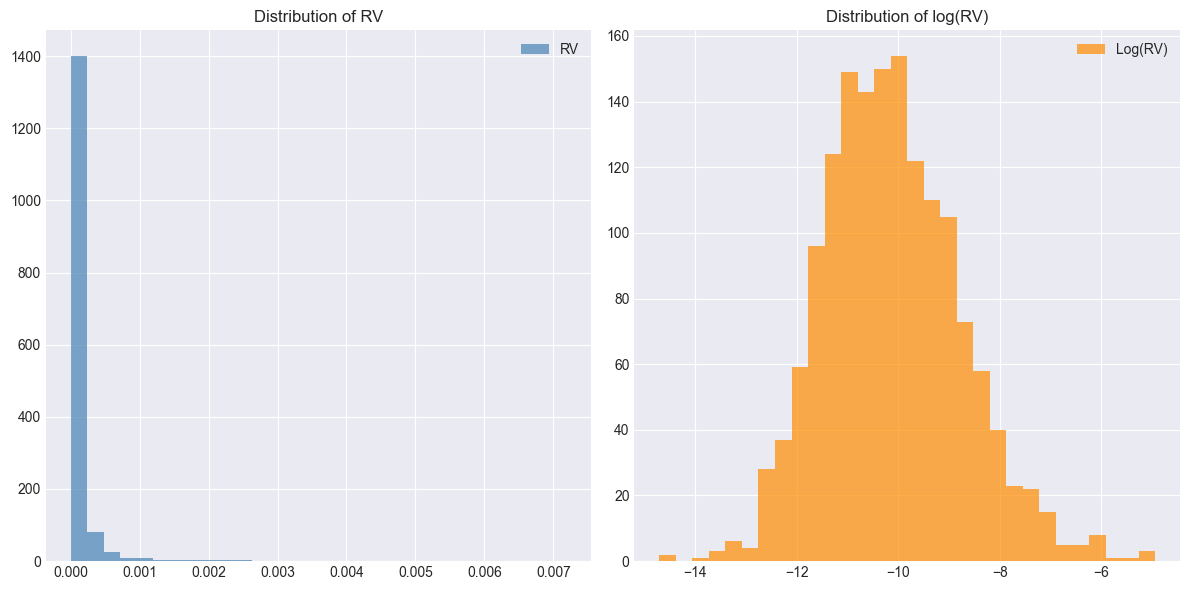

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

daily_rv.hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of RV")
axes[0].legend()

np.log(daily_rv).hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of log(RV)")
axes[1].legend()

plt.tight_layout()
plt.show()

## 3.5 Asymmetry / Leverage Effect

Another key stylized fact is the **asymmetric relation between returns and volatility**:  
- Negative returns (price drops) tend to increase future volatility more than positive returns of the same magnitude.  
- This is often called the **leverage effect**, since a fall in equity prices increases financial leverage, making the firm riskier.  
- In practice, this creates an asymmetric volatility–return correlation:
  - Correlation between returns and future volatility < 0.

**Modeling implications:**
- Symmetric models (e.g., standard GARCH) cannot capture this.  
- Asymmetric extensions such as EGARCH, GJR-GARCH, or stochastic volatility with leverage are used to account for it.  

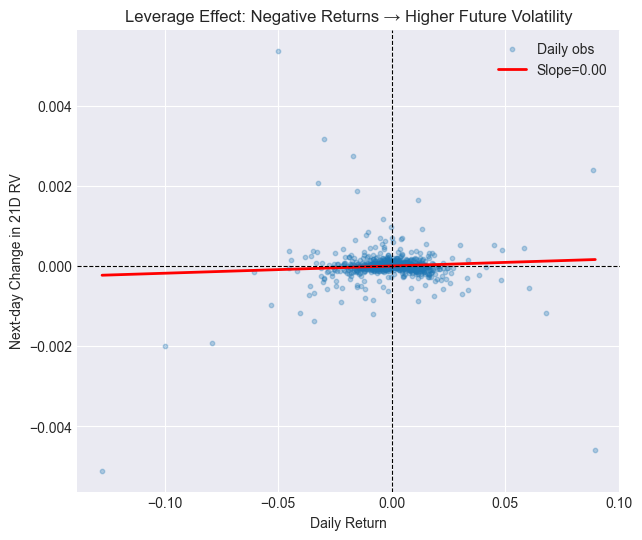

In [30]:
# --- Next-day change in volatility ---
dvol = daily_rv.shift(-1) - daily_rv   # Δvol at t+1

# Align
df = pd.concat([spx["returns"], dvol], axis=1).dropna()
df.columns = ["ret", "dvol"]

# --- Scatterplot ---
fig, ax = plt.subplots(figsize=(7,6))
ax.scatter(df["ret"], df["dvol"], alpha=0.3, s=10, label="Daily obs")

# Fit regression line
m, b = np.polyfit(df["ret"], df["dvol"], 1)
x_vals = np.linspace(df["ret"].min(), df["ret"].max(), 100)
ax.plot(x_vals, m*x_vals + b, color="red", lw=2, label=f"Slope={m:.2f}")

# Axes + titles
ax.axhline(0, color="black", ls="--", lw=0.8)
ax.axvline(0, color="black", ls="--", lw=0.8)
ax.set_xlabel("Daily Return")
ax.set_ylabel("Next-day Change in 21D RV")
ax.set_title("Leverage Effect: Negative Returns → Higher Future Volatility")
ax.legend()

plt.show()

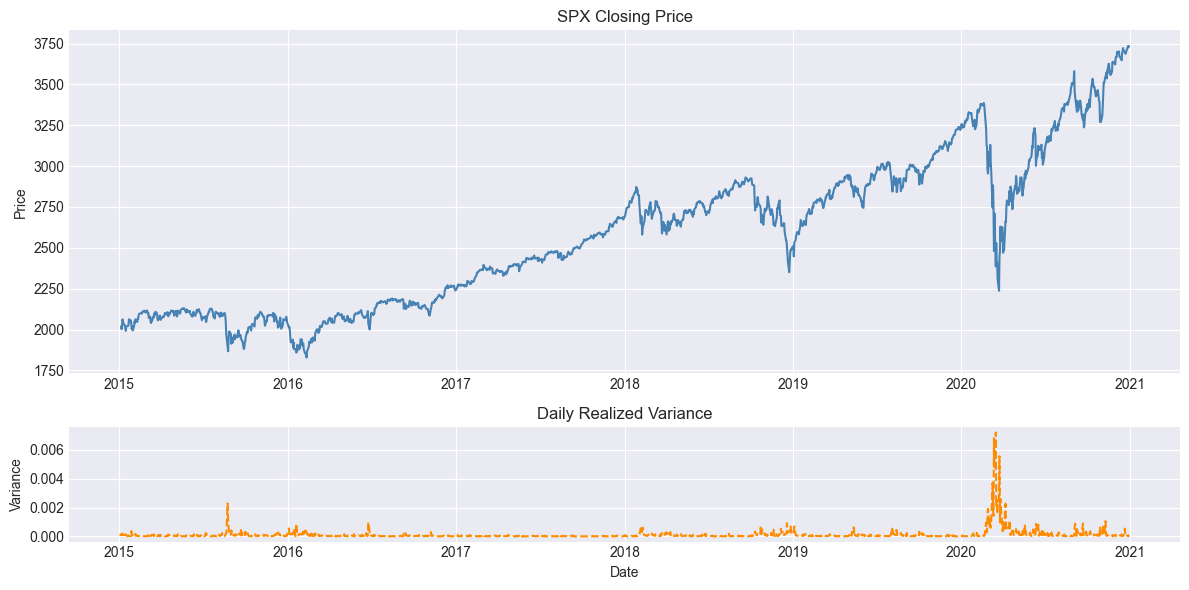

In [31]:
fig = plt.figure(figsize=(12,6))
gs = gridspec.GridSpec(2, 1, height_ratios=[3, 1])  # top 3x bigger than bottom

# Top: SPX closing price
ax1 = fig.add_subplot(gs[0])
ax1.plot(spx.index, spx["Close"], color="steelblue")
ax1.set_title("SPX Closing Price")
ax1.set_ylabel("Price")

# Bottom: realized volatility
ax2 = fig.add_subplot(gs[1], sharex=ax1)
ax2.plot(daily_rv.index, daily_rv, color="darkorange", linestyle="--")
ax2.set_title("Daily Realized Variance")
ax2.set_ylabel("Variance")
ax2.set_xlabel("Date")

plt.tight_layout()
plt.show()

Here we can see that durign stress regimes voalitltiy tend to spike.

# **5. Problem Formulation**

We frame the task as a supervised learning problem: forecasting the 21-day forward realized volatility of the S&P 500.

Formally, the objective is to predict forward realized volatility using only information available at time $t$.  

$$
y_t = f(X_t; \beta) + \varepsilon_t, \quad \text{with } \mathbb{E}[y_t | X_t] = f(X_t; \beta)
$$

where:
- $y_t$ = target variable (forward 21-day realized volatility),
- $X_t$ = vector of predictors at time $t$.
- $f(.;\beta)$ = parametric or non-parametric form of the regressors


## 5.1 Target Variable: 21-Day Realized Variance

For forecasting purposes, it is convenient to define the target in terms of **daily realized volatility** averaged over the forward horizon.  
This follows the econometric convention (Christoffersen, Corsi, etc.), where multi–day realized volatility is expressed as the mean of daily RVs rather than as total variance.

Since realized variance and volatility are highly skewed and approximately log-normal, we work in the **logarithmic scale**:

$$
y_t = \log\!\big(RV_{t+1:t+21}\big)
$$

where the forward 21-day realized variance aligned at time $t$ is defined as:

$$
RV_{t+1:t+21} 
= \frac{RV_{t+1} + RV_{t+2} + \cdots + RV_{t+21}}{21}
$$

with $RV_{t+i}$ denoting the one-day realized volatility computed from intraday (5-min) returns.

- The **log transform** reduces skewness, stabilizes variance, and makes the distribution closer to Gaussian.  
- It also guarantees positivity when transformed back:

$$
\hat{RV}_{t+1:t+21} = \exp(\hat{y}_t).
$$

In [32]:
H = 21

def create_target(real_variance, h=21):
    y = real_variance.rolling(h).mean().shift(-h)
    return np.log(y)

y = create_target(daily_rv, h=H)

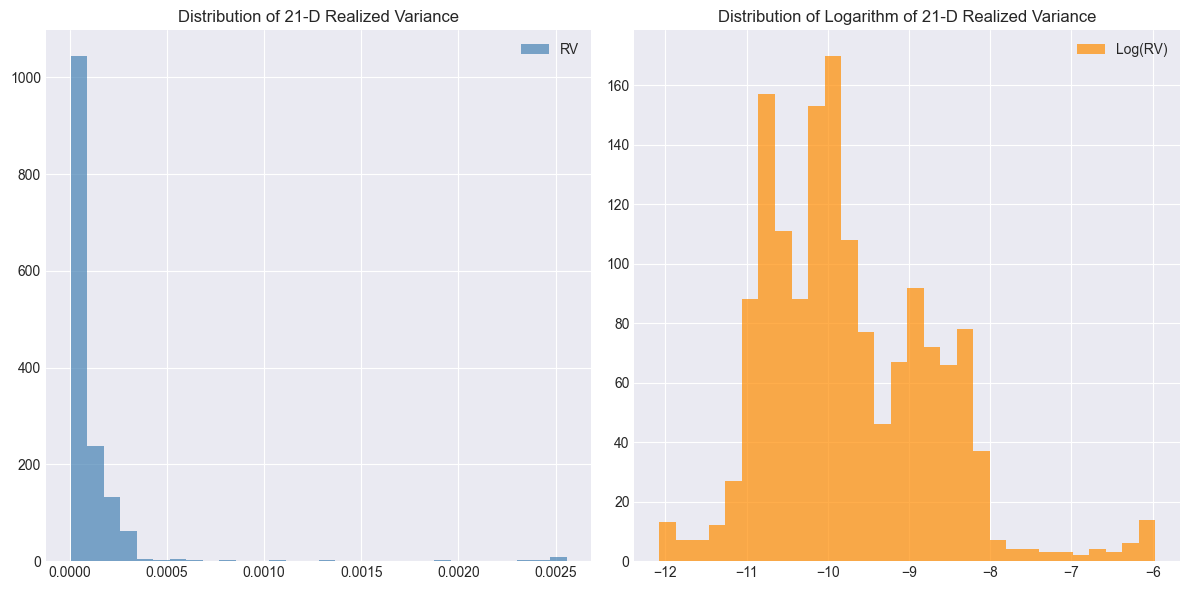

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

np.exp(y).hist(bins=30, ax=axes[0], label="RV", color="steelblue", alpha=0.7)
axes[0].set_title("Distribution of 21-D Realized Variance")
axes[0].legend()

y.hist(bins=30, ax=axes[1], label="Log(RV)", color="darkorange", alpha=0.7)
axes[1].set_title("Distribution of Logarithm of 21-D Realized Variance")
axes[1].legend()

plt.tight_layout()
plt.show()

## 4. Predictor Families

We use features observable at time (t), grouped into families where each fmailly covers one parituclar aspect of the foward RV.

### 4.1 Lagged Volatility Measures: HAR-RV Lags (1D, 5D, 22D)

As seen in the ACF plots, realized variance exhibits strong persistence, remaining significant up to at least 21 lags. This motivates the use of **lagged realized variance/volatility** as predictors.

A common specification is the **HAR-RV (Heterogeneous Autoregressive) structure**, which captures short, medium, and long-term memory effects by including daily, weekly, and monthly averages of past realized variance:

$$
X_{t}^{HAR} = RV_{D,t} + RV_{W,t} + RV_{M,t}
$$

where:
- $RV_{D,t} = RV_{t}$ (daily lag, short-term persistence)  
- $RV_{W,t} = \tfrac{1}{5}\sum_{i=0}^{4} RV_{t-i}$ (weekly average, medium-term)  
- $RV_{M,t} = \tfrac{1}{21}\sum_{i=0}^{20} RV_{t-i}$ (monthly average, long-term)  

This formulation smooths noisy daily lags and reflects the heterogeneous behavior of different market participants (daily traders, weekly rebalancers, monthly institutions).

In [60]:
def create_har_lags(real_variance):
    X_har = pd.DataFrame({
        "RV_D": real_variance,                   # yesterday’s daily RV
        "RV_W": real_variance.rolling(5).mean(), # weekly avg of daily RVs
        "RV_M": real_variance.rolling(21).mean() # monthly avg of daily RVs
    })
    return X_har

X_har = create_har_lags(daily_rv)

In [61]:
summary_stats = ['count','mean','std','min','max','skew','kurtosis']

X_har = create_har_lags(daily_rv)
X_har.agg(summary_stats)

,RV_D,RV_W,RV_M
count,1.547000e+03,1543.000000,1527.000000
mean,1.211085e-04,0.000121,0.000121
std,3.968569e-04,0.000336,0.000283
min,4.072668e-07,0.000004,0.000006
max,7.191973e-03,0.004678,0.002556
skew,1.117544e+01,8.696364,6.585905
kurtosis,1.602351e+02,90.721703,47.319494


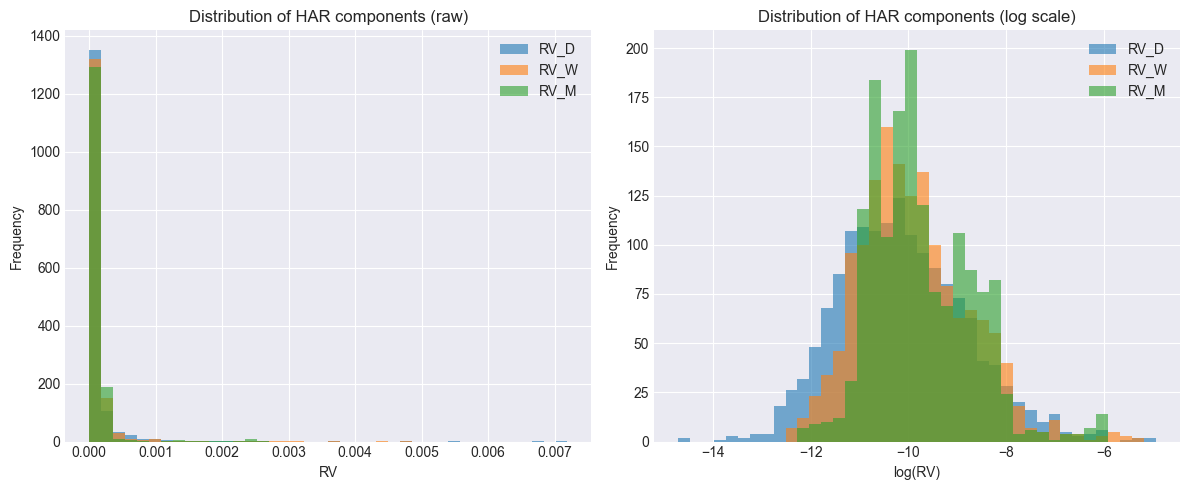

In [35]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

X_har.plot.hist(
    bins=40, alpha=0.6, ax=axes[0], legend=True
)
axes[0].set_title("Distribution of HAR components (raw)")
axes[0].set_xlabel("RV")

np.log(X_har).plot.hist(
    bins=40, alpha=0.6, ax=axes[1], legend=True
)
axes[1].set_title("Distribution of HAR components (log scale)")
axes[1].set_xlabel("log(RV)")

plt.tight_layout()
plt.show()

### Apply log-transformation to HAR-RV lags

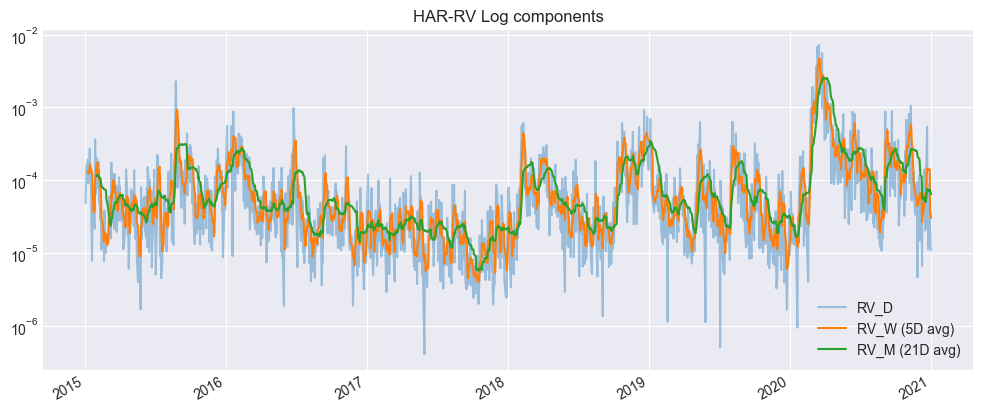

In [36]:
fig, ax = plt.subplots(1,1, figsize=(12,5))
ax.set_yscale("log")
X_har["RV_D"].plot(ax=ax, alpha=0.4, label="RV_D")
X_har["RV_W"].plot(ax=ax, alpha=1, label="RV_W (5D avg)")
X_har["RV_M"].plot(ax=ax, alpha=1, label="RV_M (21D avg)")
plt.legend(); plt.title("HAR-RV Log components")
plt.show()

In [90]:
def plot_features_vs_target(X, y, log_features=None, figsize=(12, 6), cmap="viridis", nrows=None, ncols=None):
    log_features = log_features or []

    if not ncols:
        n_cols = len(X.columns)
        ncols = 2

    if not nrows:
        nrows = (n_cols + 1) // 2

    fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
    axes = axes.flatten()

    for ax, col in zip(axes, X.columns):
        x = X[col].to_numpy()

        if col in log_features:
            x = np.log(x + 1e-8)  # small offset to avoid log(0)
            x_label = f"log({col})"
        else:
            x_label = col

        hb = ax.hexbin(x, y, gridsize=40, mincnt=1, cmap=cmap)
        ax.set_title(f"{x_label} vs log(y)")
        ax.set_xlabel(x_label)
        ax.set_ylabel("log(y)")
        fig.colorbar(hb, ax=ax, shrink=0.8)

    plt.tight_layout()
    plt.show()

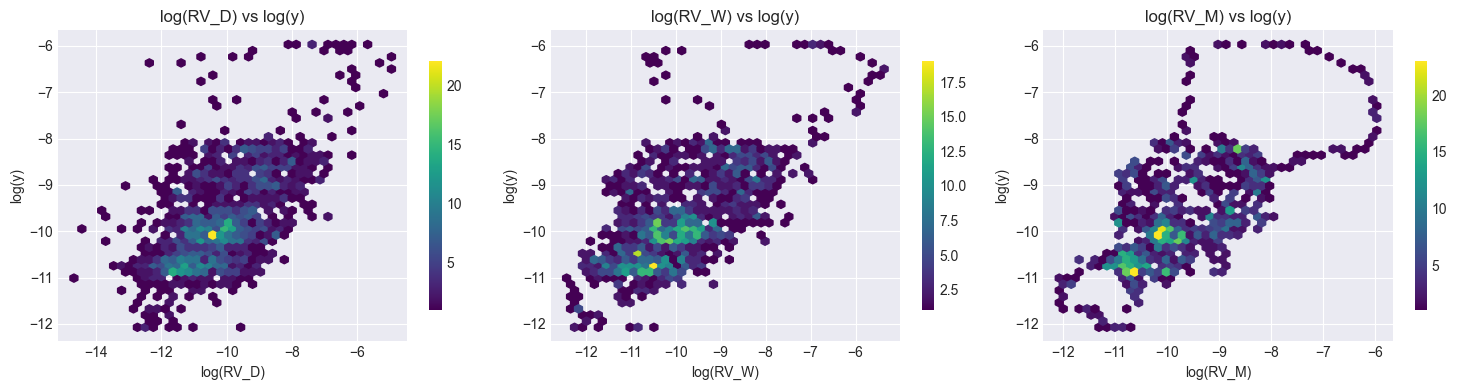

In [59]:
plot_features_vs_target(X_har, y, log_features=X_har.columns.tolist(), figsize=(15, 4), nrows=1, ncols=3)

#### **Transformation Decisions**
- Apply `log` transform to: `RV_D`, `RV_W`, `RV_M`.

### 4.2 Implied Volatility Signals

While realized volatility lags capture persistence, implied volatility (IV) embeds the market’s **forward-looking expectations** of future volatility.  
We can distinguish two main sources of IV-based predictors:

#### 4.2.1 VIX Family Indices
- **VIX**: benchmark measure of 30-day implied variance/volatility; model-free, constructed from SPX options.  
- **VVIX**: the “volatility of volatility index,” measuring the implied variability of VIX itself.  
- **VIX Futures Term Structure**: slope or ratio of front-month vs. back-month VIX futures (VX1, VX2); backwardation is often a stress signal.

In [63]:
X_vix = yf.download(["^VIX", "^VVIX"], start=start, end=end, auto_adjust=True)[["Close"]]
X_vix.columns = ["VIX", "VVIX"]

[*********************100%***********************]  2 of 2 completed


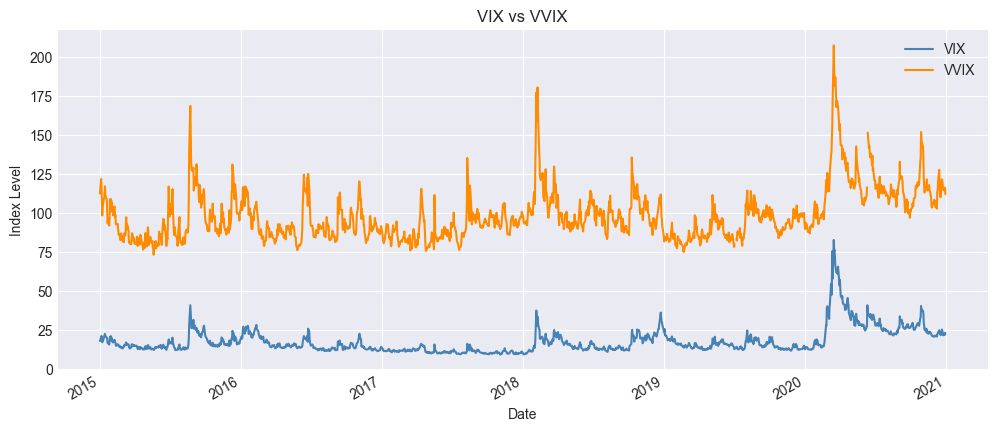

In [64]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,5))
X_vix["VIX"].plot(ax=ax, label="VIX", color="steelblue")
X_vix["VVIX"].plot(ax=ax, label="VVIX", color="darkorange")
ax.set_title("VIX vs VVIX")
ax.set_ylabel("Index Level")
ax.legend()
plt.show()

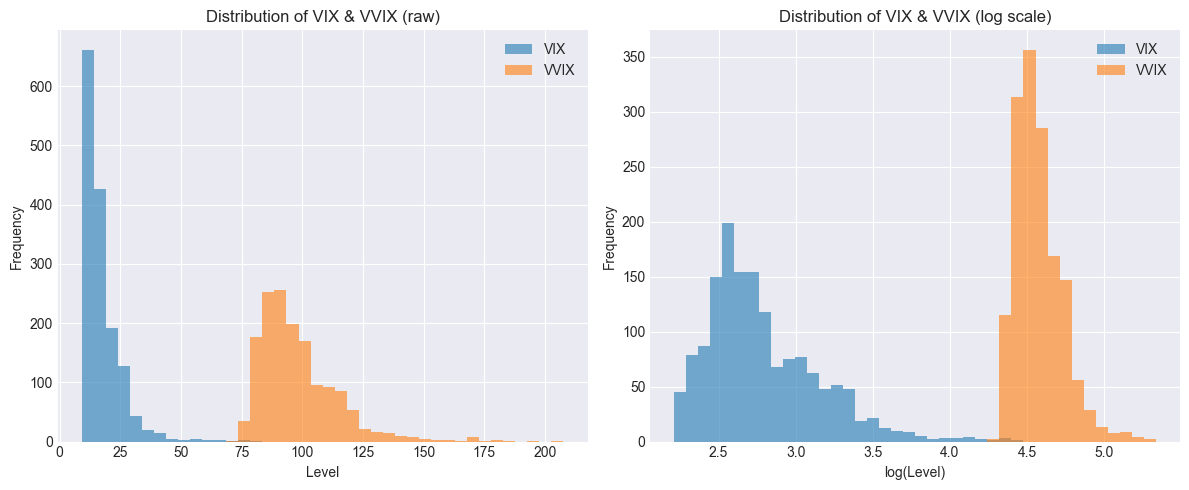

In [65]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# --- Left: raw levels ---
X_vix.plot.hist(
    bins=40, alpha=0.6, ax=axes[0], legend=True
)
axes[0].set_title("Distribution of VIX & VVIX (raw)")
axes[0].set_xlabel("Level")

# --- Right: log levels ---
np.log(X_vix).plot.hist(
    bins=40, alpha=0.6, ax=axes[1], legend=True
)
axes[1].set_title("Distribution of VIX & VVIX (log scale)")
axes[1].set_xlabel("log(Level)")

plt.tight_layout()
plt.show()

In [66]:
X_vix = X_vix.reindex(y.index).ffill()

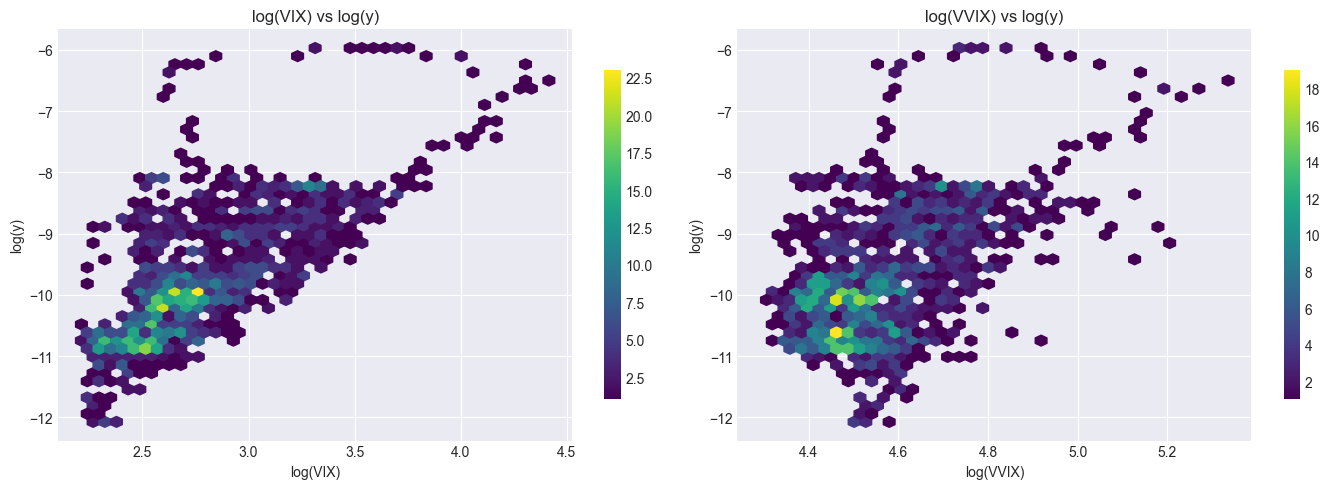

In [71]:
plot_features_vs_target(X_vix, y, log_features=X_vix.columns.tolist(), figsize=(14, 5))

#### 4.2.2 Option Surface-Based Predictors
- **ATM IV (1M maturity)**: closer to the traded option premium; less skew-contaminated than VIX.  
- **IV Skew/Slope**: difference between OTM put IV and ATM IV, proxy for downside risk premium.  
- **IV Term Structure**: slope between short- and long-dated IVs (e.g., 1M vs 3M); inverted term structure signals near-term stress.

In [72]:
spx_options = pd.read_parquet("data/intermediate/full_spx_options_2016_2023.parquet")
spx_options = spx_options.loc[:"2020"]

spx_options["T"] = spx_options["dte"] / 252 # Time to expity in years
spx_options["k"] = np.log(
    spx_options["strike"] / spx_options["underlying_last"] # Log-forward moneyness
 )

In [73]:
def create_iv_surface_predictors(options, iv_surface_model, params=None):
    iv_features = []

    for date, chain in options.groupby("date"):
        # # --- Underlying spot (ATM anchor) ---   
        S = float(chain["underlying_last"].iloc[0])

        # --- Fit or restore the surface ---     
        if params is None or date not in params:
            iv_surface_model.fit(chain)
        else:
            iv_surface_model.set_params({**params[date], "spot": S})

        # --- ATM IVs ---
        atm_iv_30 = iv_surface_model.implied_vol(S, 30/252)
        atm_iv_60 = iv_surface_model.implied_vol(S, 60/252)

        # --- Skew proxy (strikes 0.8S vs 1.1S, 30d maturity) ---
        iv_put = iv_surface_model.implied_vol(0.8 * S, 30/252)
        iv_call = iv_surface_model.implied_vol(1.1 * S, 30/252)
        iv_skew = iv_put - iv_call

        # --- Term structure slope (per 30 days) ---
        iv_ts = (atm_iv_60 - atm_iv_30)

        iv_features.append({
            "date": date,
            "atm_iv_30d": atm_iv_30,
            "atm_iv_60d": atm_iv_60,
            "iv_skew": iv_skew,
            "iv_ts": iv_ts
        })

    iv_features = pd.DataFrame(iv_features).set_index("date").sort_index()
    return iv_features

In [ ]:
from src.iv_surface.ssvi_model import SSVI

ssvi = SSVI()
df_g = pd.read_parquet("ssvi_globals_2016_2020.parquet")
df_k = pd.read_parquet("ssvi_knots_2016_2020.parquet")

params_ssvi = ssvi.build_params_dict(df_g, df_k)
X_iv_surface = create_iv_surface_predictors(spx_options, ssvi, params=params_ssvi)

,atm_iv_30d,atm_iv_60d,iv_skew,iv_ts
count,1250.000000,1250.000000,1250.000000,1250.000000
mean,0.143186,0.150816,0.207231,0.007630
std,0.079951,0.072479,0.057205,0.012085
min,0.062058,0.072995,-0.501141,-0.087146
max,0.776023,0.701308,0.351760,0.054624
skew,2.967626,2.747820,-7.078975,-2.537610
kurtosis,13.601684,11.713882,83.158174,13.458710


#### Correct data error from iv puts

In [78]:
X_iv_surface.loc["2019-05-02":"2019-05-08", :] = np.nan
X_iv_surface.loc["2019-05-17", :] = np.nan
X_iv_surface = X_iv_surface.interpolate(method="linear")

X_iv_surface.agg(summary_stats)

,atm_iv_30d,atm_iv_60d,iv_skew,iv_ts
count,1250.000000,1250.000000,1250.000000,1250.000000
mean,0.142728,0.150150,0.210405,0.007422
std,0.079572,0.071806,0.034638,0.011855
min,0.062058,0.072995,0.138110,-0.087146
max,0.776023,0.701308,0.351760,0.040960
skew,3.009901,2.807282,0.807335,-2.770637
kurtosis,13.955607,12.259400,0.549239,14.157403


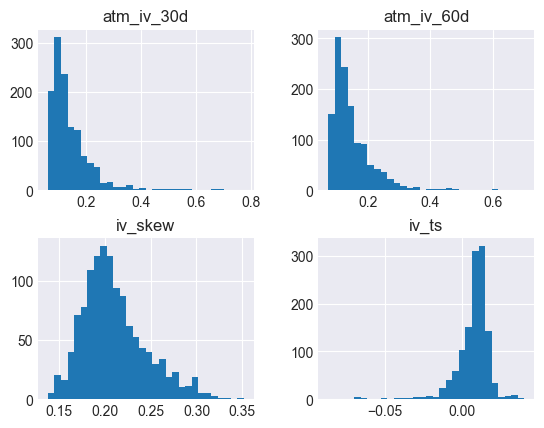

In [82]:
X_iv_surface.hist(bins=30)
plt.show()

#### **Transformation Decisions**
- Apply `log` transform to: `VIX`, `VVIX`, `iv_atm_30`, `iv_atm_60`.
- Apply Yeo-Johnson transform to: `iv_ts`

*Remarque*:
Could apply log transform to iv_skew but since it has moderate skewness < 1
we decide to keep the original predictor

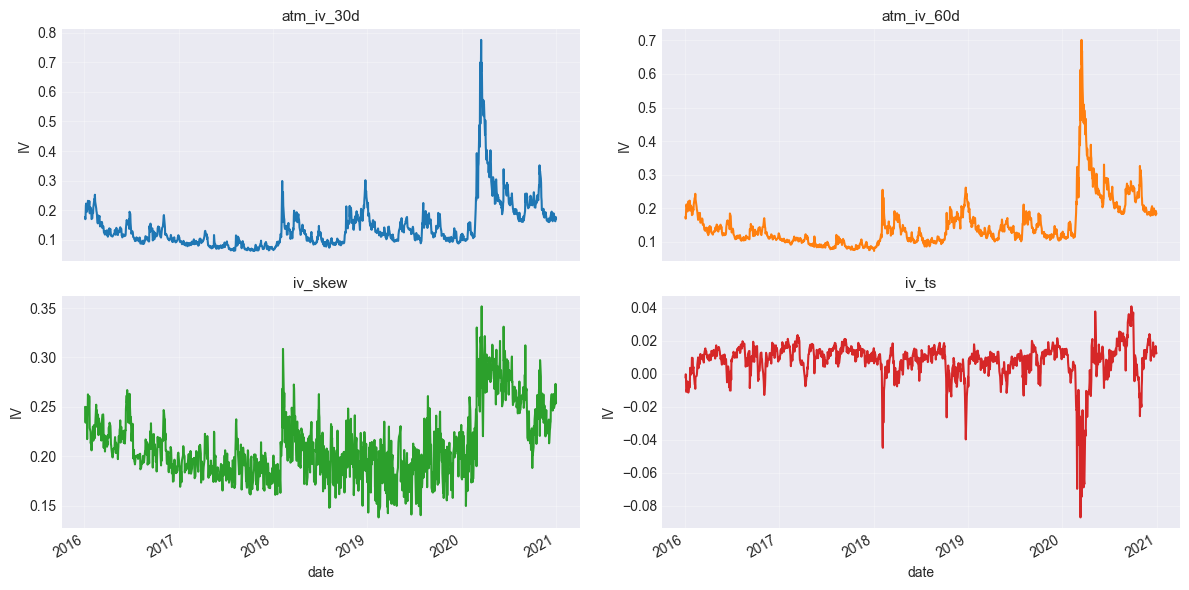

In [80]:
colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]  # blue, orange, green, red

fig, axes = plt.subplots(2, 2, figsize=(12, 6), sharex=True)

for ax, col, c in zip(axes.flat, X_iv_surface.columns, colors):
    X_iv_surface[col].plot(ax=ax, lw=1.5, color=c)
    ax.set_title(col, fontsize=11)
    ax.grid(alpha=0.3)
    ax.set_ylabel("IV")
    
plt.tight_layout()
plt.show()

In [84]:
X_iv_surface = X_iv_surface.reindex(y.index).ffill()

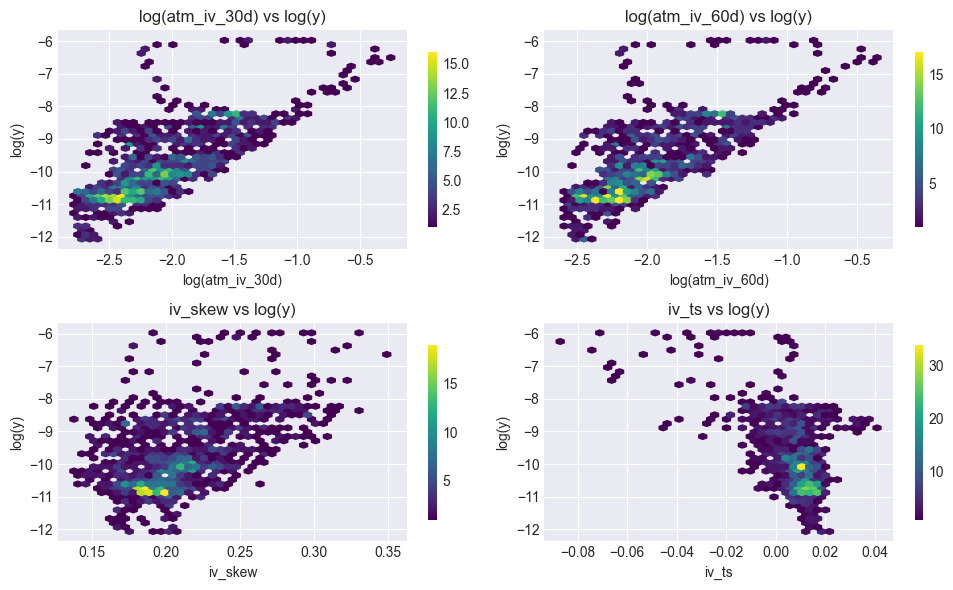

In [97]:
plot_features_vs_target(X_iv_surface, y, log_features=["atm_iv_30d","atm_iv_60d"], figsize=(10, 6))

### 4.3 Return-related predictors: absolute returns, past squared returns, Realized skewness / kurtosis

In [98]:
def create_return_predictors(returns: pd.Series, h: int = 21) -> pd.DataFrame:
    ret_features = pd.DataFrame(index=returns.index)

    # Absolute and squared returns
    ret_features["abs_r"] = returns.abs()
    ret_features["r2"] = returns.pow(2)

    # Rolling averages
    ret_features["avg_abs_r_5"] = returns.abs().rolling(5).mean()
    ret_features["avg_r2_5"] = returns.pow(2).rolling(5).mean()

    # Realized skewness & kurtosis over horizon h
    rolling_r = returns.rolling(h)
    std = rolling_r.std()
    ret_features["skew"] = rolling_r.apply(lambda x: ((x / x.std())**3).mean(), raw=False)
    ret_features["kurt"] = rolling_r.apply(lambda x: ((x / x.std())**4).mean(), raw=False)

    return ret_features

In [101]:
X_returns = create_return_predictors(spx["returns"])
X_returns = X_returns.reindex(y.index).ffill()
X_returns.agg(summary_stats)

,abs_r,r2,avg_abs_r_5,avg_r2_5,skew,kurt
count,1546.000000,1546.000000,1542.000000,1.542000e+03,1525.000000,1525.000000
mean,0.007059,0.000138,0.007094,1.383843e-04,0.157657,3.419456
std,0.009373,0.000658,0.007179,5.006325e-04,1.015985,1.507768
min,0.000000,0.000000,0.000874,9.880867e-07,-3.208464,1.457295
max,0.127652,0.016295,0.085571,8.078781e-03,3.103612,13.121545
skew,4.714721,15.241174,5.090031,1.117129e+01,0.015911,1.803325
kurtosis,37.750405,300.882398,40.163995,1.492615e+02,-0.289544,4.315529


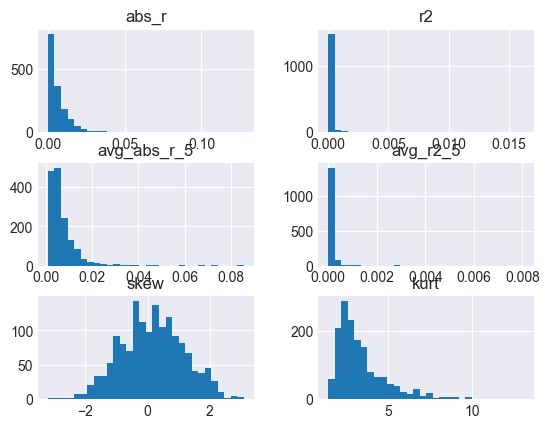

In [117]:
X_returns.hist(bins=30)
plt.show()

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_74925/1524026933.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(X_returns[col].to_numpy()),
/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_74925/1524026933.py:5: RuntimeWarning: invalid value encountered in log
  np.log(X_returns[col].to_numpy()),


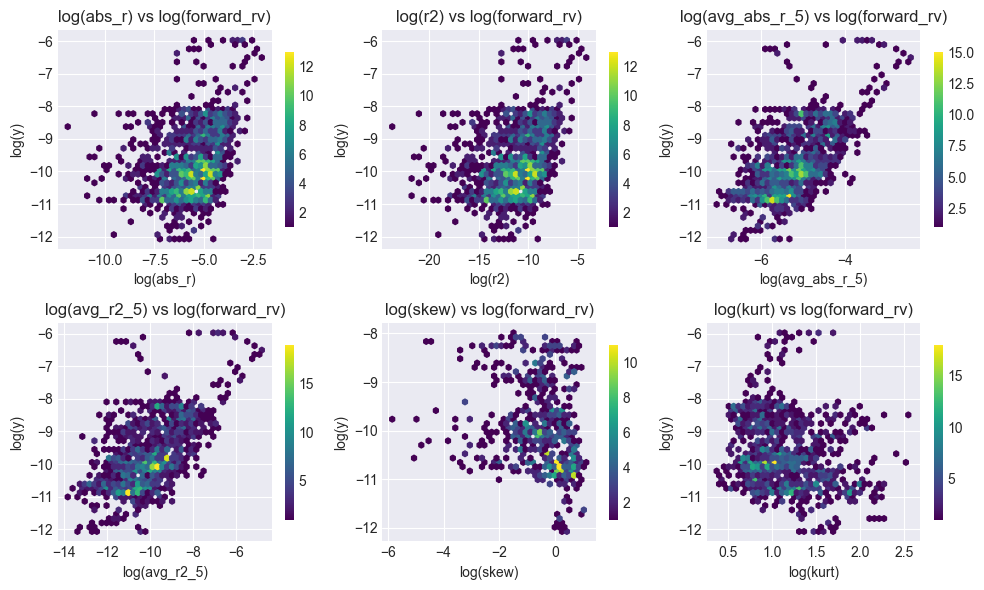

In [58]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ax, col in zip(axes.flat, X_returns.columns):
    hb = ax.hexbin(
        np.log(X_returns[col].to_numpy()), 
        y, 
        gridsize=40, 
        mincnt=1, 
        cmap="viridis"
    )
    ax.set_title(f"log({col}) vs log(forward_rv)")
    ax.set_xlabel(f"log({col})")
    ax.set_ylabel("log(y)")
    fig.colorbar(hb, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

Here we cna observe a sligth non-linearity that cna be leevraged through non-linear models.

### 4.5 Macro & Market Predictors  

This category combines **macro fundamentals** (rates, credit spreads) with **market-based measures** (volume, liquidity, realized correlations).  
Though generally less predictive than RV lags or IV signals, they can add value in stress regimes and are well suited to **machine learning models**, which can exploit non-linearities across a broader set of features.

#### 4.5.1 Macro Fundamentals  

Here we include **slow-moving economic and financial variables** that capture the broader macro environment.  
These are unlikely to explain day-to-day fluctuations in volatility but may contain information about **regime shifts** (e.g. monetary tightening, credit stress) that affect forward realized volatility:  

- **Interest rate levels & term spreads**: Treasury yields (e.g. 3M, 2Y, 10Y), slope of the yield curve.  
- **Credit spreads**: Investment-grade and high-yield spreads, proxies for systemic financial stress.  

These predictors move more slowly than market-based signals but help identify **macro-driven volatility regimes** (e.g. high-rate environments, credit crises).

In [59]:
# --- Load FRED API key from environment ---
load_dotenv()
FRED = None
try:
    from fredapi import Fred
    api_key = os.getenv("FRED_API_KEY")  # loaded from .env or system env
    if api_key:
        FRED = Fred(api_key=api_key)
        print("✅ FRED API loaded.")
    else:
        print("⚠️ No FRED API key found in environment. Macro features will be empty.")
except ImportError:
    print("⚠️ fredapi not installed. Install with `pip install fredapi`.")

# --- Helper to fetch a single FRED series ---
def _fred_series(series_id, start=None, end=None):
    if FRED is None:
        return pd.Series(dtype=float, name=series_id)
    s = FRED.get_series(series_id, observation_start=start, observation_end=end)
    s = pd.Series(s, name=series_id)
    s.index = pd.to_datetime(s.index)
    return s

# --- Main macro feature builder ---
def create_macro_features(start="2005-01-01", end=None):
    # --- Treasury yields ---
    DGS10  = _fred_series("DGS10",  start, end).rename("DGS10")   # 10Y yield (%)
    DGS2   = _fred_series("DGS2",   start, end).rename("DGS2")    # 2Y yield (%)
    DGS3MO = _fred_series("DGS3MO", start, end).rename("DGS3MO")  # 3M yield (%)
    term_spread = (DGS10 - DGS3MO).rename("term_spread_10y_3m")

    # --- Credit spreads ---
    HY_OAS = _fred_series("BAMLH0A0HYM2", start, end).rename("HY_OAS")   # High Yield OAS (%)
    IG_OAS = _fred_series("BAMLC0A0CM",   start, end).rename("IG_OAS")   # IG OAS (%)

    # --- Assemble ---
    df = pd.concat([DGS10, DGS2, DGS3MO, term_spread, HY_OAS, IG_OAS], axis=1).sort_index()

    # Business-day frequency; forward-fill for sparse macro data
    df = df.asfreq("B")
    df = df.ffill()

    return df

✅ FRED API loaded.


In [60]:
X_macro = create_macro_features(start="2015", end="2020-12-31")

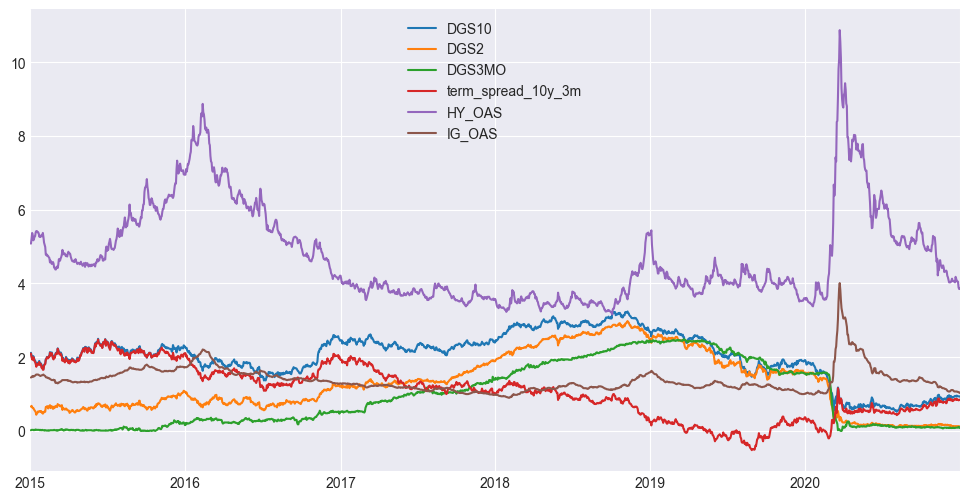

In [61]:
X_macro.plot(figsize=(12, 6))
plt.show()

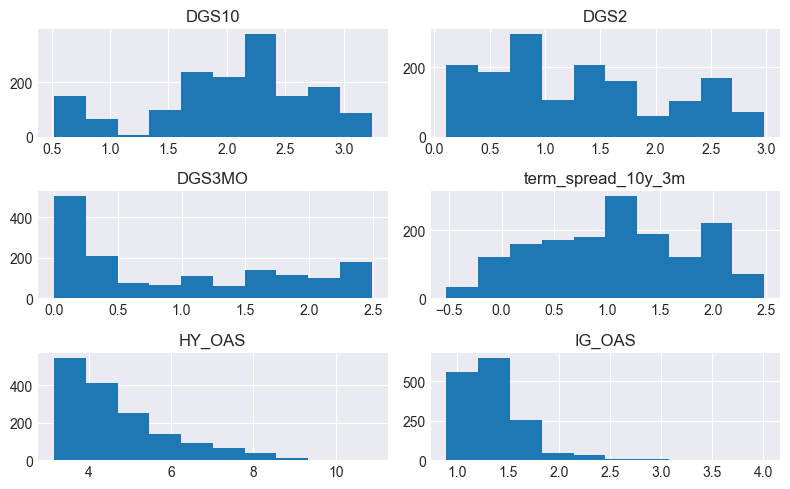

In [62]:
X_macro.hist(figsize=(8, 5))
plt.tight_layout()
plt.show()

In [65]:
X_macro = X_macro.reindex(y.index).ffill()

/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_74925/3537959099.py:5: RuntimeWarning: divide by zero encountered in log
  np.log(X_macro[col].to_numpy()),
/var/folders/4c/lbq7ysyx5zl93htfdcbr02br0000gn/T/ipykernel_74925/3537959099.py:5: RuntimeWarning: invalid value encountered in log
  np.log(X_macro[col].to_numpy()),


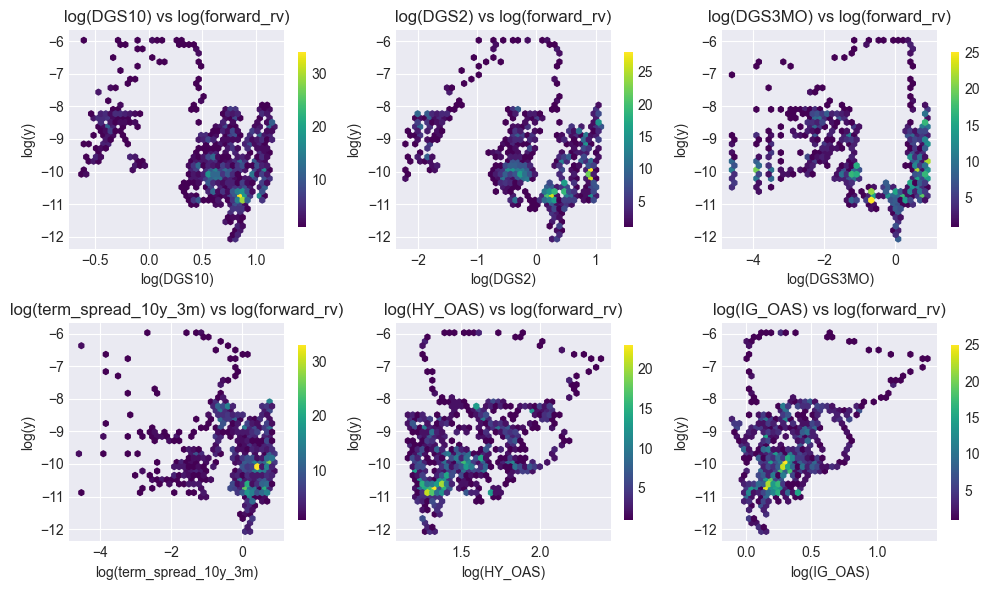

In [66]:
fig, axes = plt.subplots(2, 3, figsize=(10, 6))

for ax, col in zip(axes.flat, X_macro.columns):
    hb = ax.hexbin(
        np.log(X_macro[col].to_numpy()), 
        y, 
        gridsize=40, 
        mincnt=1, 
        cmap="viridis"
    )
    ax.set_title(f"log({col}) vs log(forward_rv)")
    ax.set_xlabel(f"log({col})")
    ax.set_ylabel("log(y)")
    fig.colorbar(hb, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

In [119]:
from sklearn.ensemble import RandomForestRegressor

X = pd.concat([X_har, X_vix, X_iv_surface, X_returns, X_macro], axis=1)

In [68]:
X

,RV_D,RV_W,RV_M,VIX,VVIX,atm_iv_30d,atm_iv_60d,iv_skew,iv_ts,DGS10,DGS2,DGS3MO,term_spread_10y_3m,HY_OAS,IG_OAS
2015-01-02,-9.948056,NaN,NaN,2.878637,4.723398,NaN,NaN,NaN,NaN,2.12,0.66,0.02,2.10,5.08,1.45
2015-01-05,-8.745787,NaN,NaN,2.991724,4.802955,NaN,NaN,NaN,NaN,2.04,0.68,0.03,2.01,5.21,1.46
2015-01-06,-9.166663,NaN,NaN,3.050220,4.774491,NaN,NaN,NaN,NaN,1.97,0.65,0.03,1.94,5.37,1.48
2015-01-07,-8.984515,NaN,NaN,2.960623,4.679257,NaN,NaN,NaN,NaN,1.96,0.62,0.03,1.93,5.31,1.49
2015-01-08,-8.564941,-8.983323,NaN,2.833801,4.589447,NaN,NaN,NaN,NaN,2.03,0.62,0.03,2.00,5.17,1.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,-11.398671,-8.892386,-9.564158,3.069447,4.747190,0.178970,0.190601,0.248820,0.011632,0.94,0.13,0.09,0.85,4.05,1.06
2020-12-28,-9.315331,-8.874196,-9.507830,3.077312,4.739701,0.162354,0.179192,0.255260,0.016838,0.94,0.13,0.11,0.83,3.89,1.05
2020-12-29,-10.712831,-10.221633,-9.522554,3.138966,4.755915,0.177423,0.191667,0.273264,0.014244,0.94,0.12,0.10,0.84,3.85,1.05
2020-12-30,-11.045979,-10.254116,-9.584829,3.125444,4.718856,0.173484,0.185843,0.253440,0.012359,0.93,0.12,0.08,0.85,3.87,1.03


In [174]:
from sklearn.preprocessing import RobustScaler

In [181]:
data = pd.concat([X, y], axis=1)
data = data.dropna()

X_clean = data[X.columns]
y_clean = data[y.name]

In [175]:
scl = RobustScaler()

In [176]:
model = RandomForestRegressor()
model.fit(scl.fit_transform(X_clean), y_clean)

,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [125]:
importances = pd.Series(model.feature_importances_, index=X_clean.columns)
importances = importances.sort_values(ascending=True)

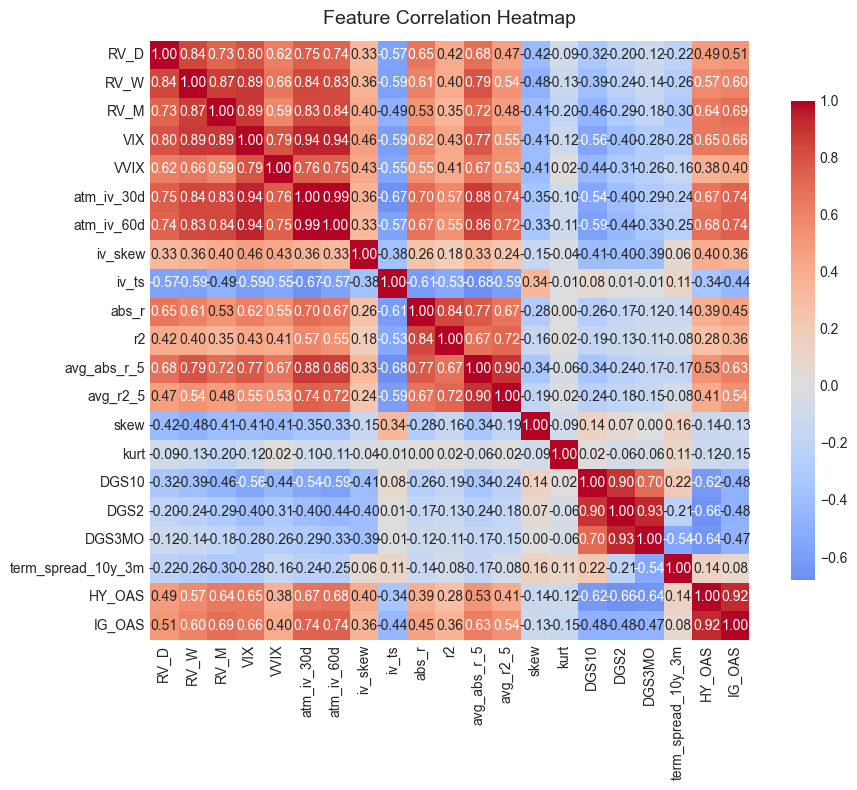

In [123]:
import seaborn as sns

plt.figure(figsize=(10, 8))  # adjust size
corr = X_clean.corr()

sns.heatmap(
    corr,
    cmap="coolwarm",        # diverging colormap
    center=0,               # put 0 in the middle of colormap
    annot=True,             # show numbers
    fmt=".2f",              # 2 decimal places
    square=True,            # square cells
    cbar_kws={"shrink": .8} # shrink colorbar
)

plt.title("Feature Correlation Heatmap", fontsize=14, pad=12)
plt.tight_layout()
plt.show()

<Axes: >

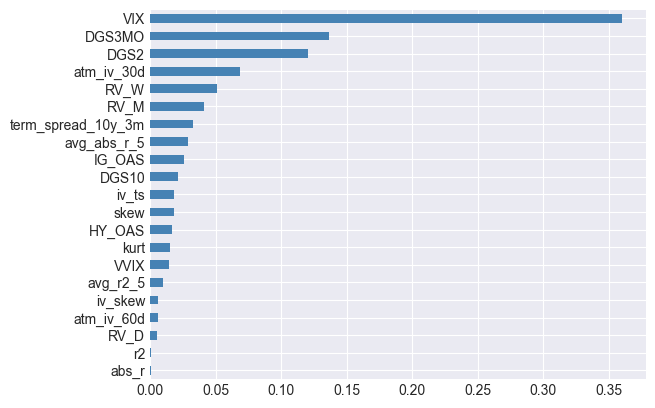

In [126]:
importances.plot(kind="barh", color="steelblue")

In [182]:
X_clean = X_clean[["VIX", "RV_W", "RV_M", "avg_abs_r_5", "DGS3MO"]]

In [184]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()

In [204]:
X_train = X_clean.loc[:"2020-06"]
y_train = y_clean.loc[:"2020-06"]

X_test = X_clean.loc["2020-07":]
y_test = y_clean.loc["2020-07":]


model.fit(X_train, y_train)

print(model.score(X_test, y_test))

0.09281276405119787


In [205]:
y_pred = pd.Series(model.predict(X_test), index=y_test.index)

In [158]:
from sklearn.metrics import r2_score, mean_squared_error

In [164]:
np.var(np.sqrt(np.exp(y_test)*252))

np.float64(0.0009516054819788732)

In [161]:
1 - mean_squared_error(np.sqrt(np.exp(y_test)*252), np.sqrt(np.exp(y_pred)*252)) / np.var(np.sqrt(np.exp(y_test)*252))

np.float64(-0.640683888209159)

In [180]:
np.corrcoef(np.sqrt(np.exp(y_test)*252), np.sqrt(np.exp(y_pred)*252))[0,1]

np.float64(0.7107588844772533)

In [165]:
r2_score(np.sqrt(np.exp(y_test) * 252), np.sqrt(np.exp(y_pred) * 252))

-0.6406838882091588

In [197]:
X_vix

,VIX,VVIX
2015-01-02,2.878637,4.723398
2015-01-05,2.991724,4.802955
2015-01-06,3.050220,4.774491
2015-01-07,2.960623,4.679257
2015-01-08,2.833801,4.589447
...,...,...
2020-12-24,3.069447,4.747190
2020-12-28,3.077312,4.739701
2020-12-29,3.138966,4.755915
2020-12-30,3.125444,4.718856


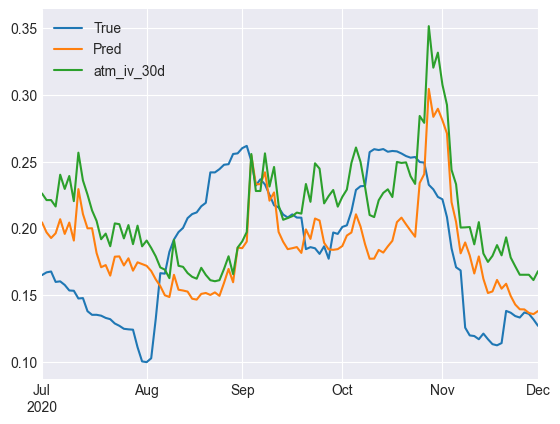

<Axes: >

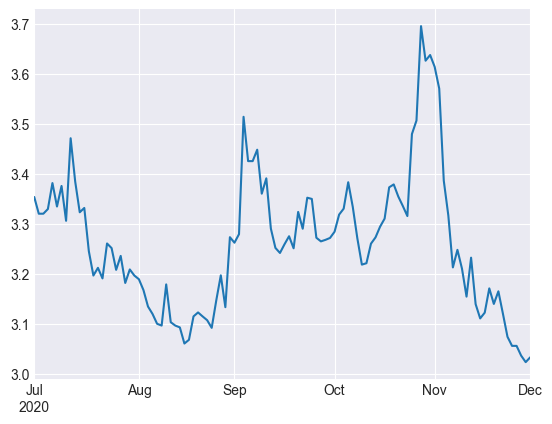

In [206]:
np.sqrt(np.exp(y_test) * 252).plot(label="True")

np.sqrt(np.exp(y_pred) * 252).plot(label="Pred")

X_iv_surface.loc[y_pred.index, "atm_iv_30d"].plot()

plt.legend()
plt.show(
    
)

X_vix.loc[y_pred.index, "VIX"].plot()

In [132]:
y_pred = pd.Series(model.predict(X_test), index=y_test.index)

<Axes: >

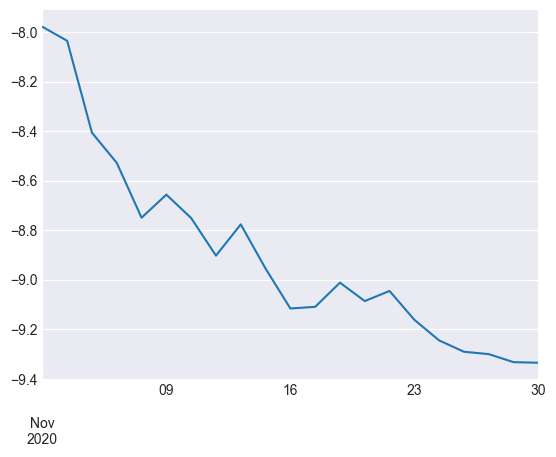

In [133]:
pd.Series(model.predict(X_test), index=y_test.index).plot()

## Boolean flags:
- Weekend effect
- Holiday effect
- FOMC meetings
- Dayofweek 

## 5. Data Processign & Feature Engineering

	•	Transformations: log(RV), log(IV), volatility ratios (IV/RV).
	•	Aggregations: rolling averages/std, realized semivariance (downside vs upside volatility).
	•	Nonlinear transforms: squares, interactions (e.g., return × volatility).
	•	Scaling/normalization if using ML.

## 4.3. Feature Selection

Filter Methods: 
    Correlation Heatmap
    Mutual Information

Wrapper methods for HAR family:
start with HAR lags + IV lags + overnight + leevarge effect + ....
and see for the top 10 features and create hAR-models accordingly (consider only the HAR-X features)

Embedded methods:
    For ML models with all features -> Embedded

•	Discuss which predictors are most important for SPX RV.

# **4. Forecasting 21-D Realized Volatility**

FOrecasting is about fitting a model that minimized a cost function -> QLIKE or RMSE

---

### Why 21-Day Horizon?

- **Options market alignment:**  
  The 21-day horizon corresponds to ~1 month of trading days, matching the 30-day maturity of the most liquid index options.  
  This is also the tenor underlying the **VIX index**, which represents the market’s expectation of 30-day implied volatility.

- **Smoother target:**  
  Forward 21-day RV is much less noisy than daily RV.  
  Aggregating returns over a month produces a smoother series, closer to a rolling mean, which helps extract meaningful patterns.  
  This improves predictive power (higher $R^2$) and makes models more robust.

In [15]:
from abc import ABC, abstractmethod

class BaseRVForecaster(ABC):
    def __init__(self, H=21, name=None):
        self.H = H
        self.name = name or self.__class__.__name__

    @abstractmethod
    def fit(self, returns: pd.Series, rv: pd.Series, **kwargs):
        """Estimate parameters using a TRAIN window (no look-ahead)."""

    def warm_state(self, returns: pd.Series, rv: pd.Series):
        """Update internal state with observed data (no parameter re-fit)."""
        return self

    @abstractmethod
    def forecast(self, as_of_index: pd.DatetimeIndex) -> pd.Series:
        """Return ex-ante H-horizon RV forecast indexed by as_of_index."""


## **4.1 Log HAR-RV**

HAR-G -> residuals are heterosckedastic

## **4.1 GARCH family of models (GARCH(1, 1), EGARCH, GJR-GARCH)**

FIGARCH / HYGARCH — for long-memory volatility (useful for multi-day forecasts).

## **4.1 Machine Learning models (Bayesian RIDGE, Lasso, Random Forest, XGboost, LSTM)**

3. Long horizon (1-month ≈ 21D forward RV, or 3M)
	•	Predictability: much higher, smoother target, strong persistence and mean reversion.
	•	Economic relevance: directly matches option tenors (VIX = 30D, 3M IV).
	•	ML: more useful here because:
	•	Nonlinearities matter (IV term structure, skew effects, macro regimes).
	•	More predictors can be included (macro, credit spreads, realized correlations).
	•	HAR/GARCH become restrictive, while ML can flexibly combine many signals.
	•	Verdict: Best horizon for ML.

## **4.1 Ensemble Model**

Take the best model of each family and create an esnbmel fo predicitons. Either simple average prediciton, or weighted preidction 1/RMSE, bayesian modelling of the weights, kalman filters for dynamic parameters, markov-swithcing models in low vs high volaility regimes.
Once a model is chsoen for a given family keep it for the all testing, jsut update the weights dinamically and refit the mdoel every month or week. 
For HAR and GARCH family of models, can use AIC and QLIKE as well as LR tets for incremental parameters.

In [16]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.linear_model import OLS
from arch import arch_model
from sklearn.ensemble import GradientBoostingRegressor

class RVForecaster:
    def __init__(self, returns, rv):
        """
        Parameters
        ----------
        returns : pd.Series
            Daily log returns of the underlying.
        rv : pd.Series
            Realized volatility series (e.g. 21D rolling, annualized).
        """
        self.returns = returns.dropna()
        self.rv = rv.dropna()
    
    # === EWMA ===
    def ewma(self, lam=0.94):
        """RiskMetrics EWMA volatility forecast."""
        sigma2 = 0
        forecasts = []
        for r in self.returns:
            sigma2 = lam * sigma2 + (1 - lam) * r**2
            forecasts.append(np.sqrt(sigma2 * 252))
        return pd.Series(forecasts, index=self.returns.index, name="EWMA")
    
    # === HAR-RV ===
    def har(self, lags=(1,5,22)):
        """HAR-RV model using daily/weekly/monthly realized vol."""
        df = pd.DataFrame({"RV": self.rv})
        for lag in lags:
            df[f"lag{lag}"] = self.rv.shift(lag).rolling(lag).mean()
        df = df.dropna()
        X = sm.add_constant(df[[f"lag{l}" for l in lags]])
        model = OLS(df["RV"], X).fit()
        forecast = model.predict(X)
        return forecast.rename("HAR-RV")
    
    # === GARCH(1,1) ===
    def garch(self):
        """GARCH(1,1) forecast."""
        model = arch_model(self.returns*100, vol="GARCH", p=1, q=1, dist="normal")
        res = model.fit(disp="off")
        forecast = res.forecast(horizon=1).variance.iloc[:,0]**0.5 / 100
        forecast = forecast.rename("GARCH(1,1)")
        return forecast
    
    # === ML (GBM by default) ===
    def ml(self, features, model=None):
        """Forecast RV using ML (GradientBoosting by default)."""
        if model is None:
            model = GradientBoostingRegressor(n_estimators=200, max_depth=3)
        X = features.shift(1).dropna()
        y = self.rv.loc[X.index]
        model.fit(X, y)
        forecast = pd.Series(model.predict(X), index=X.index, name="ML-RV")
        return forecast

ModuleNotFoundError: No module named 'arch'